# 0ggF and 1ggF plots with SR selections (MC and data)


--- Channel: 0ggF ---


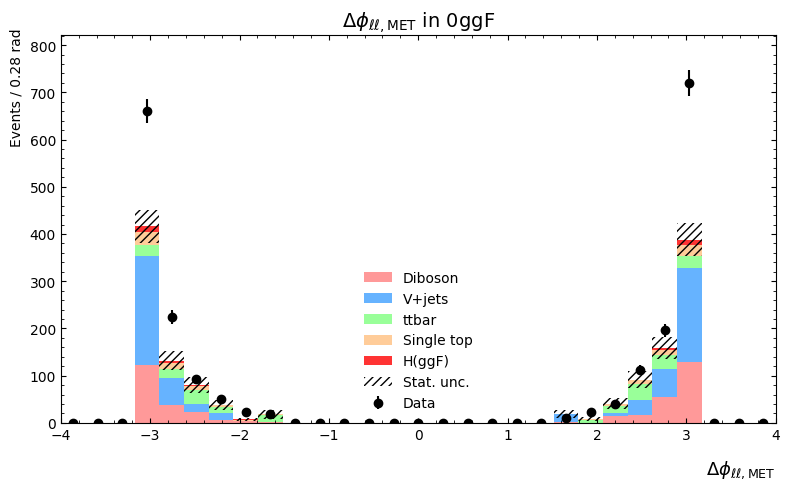

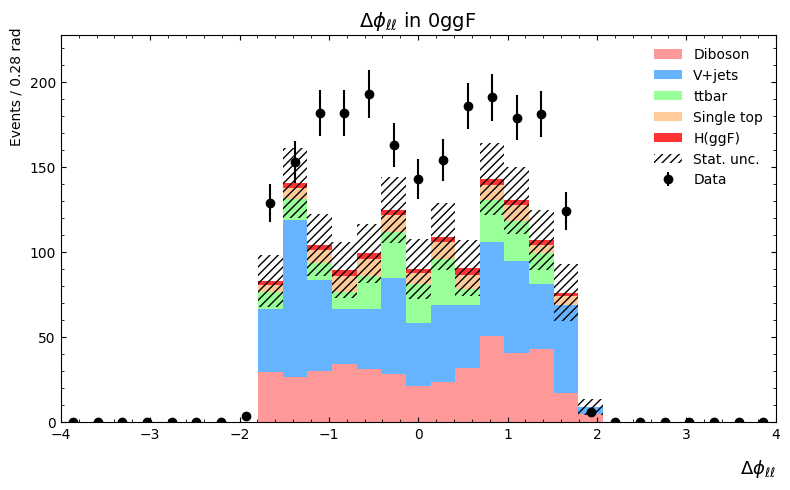

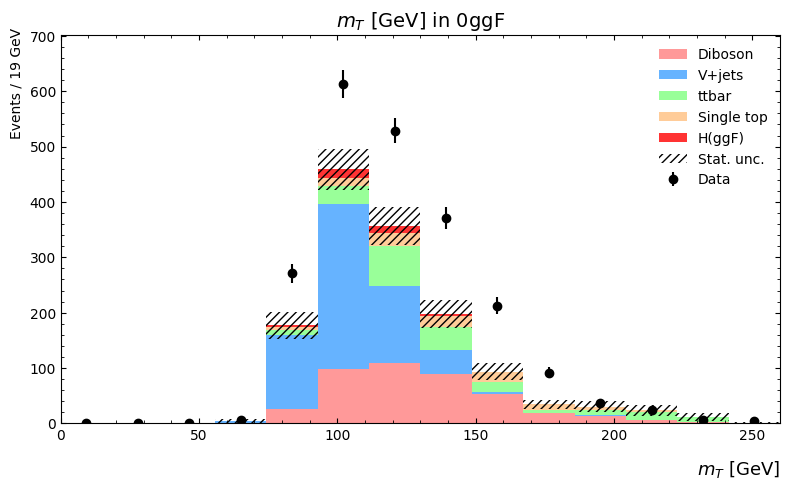

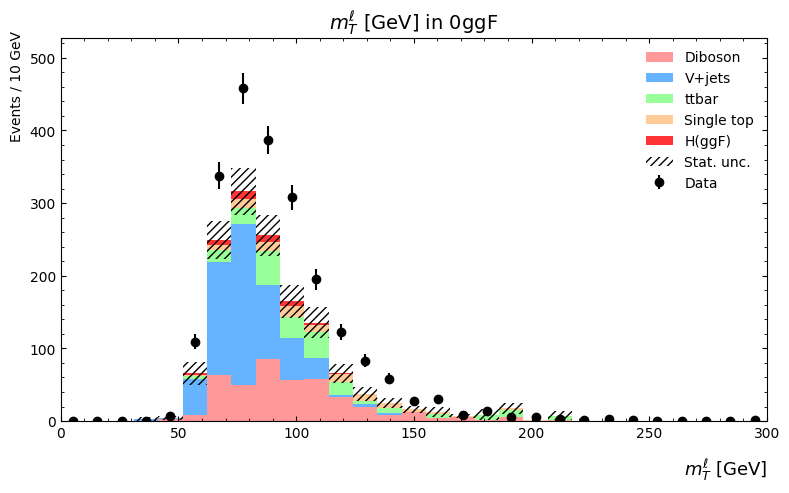

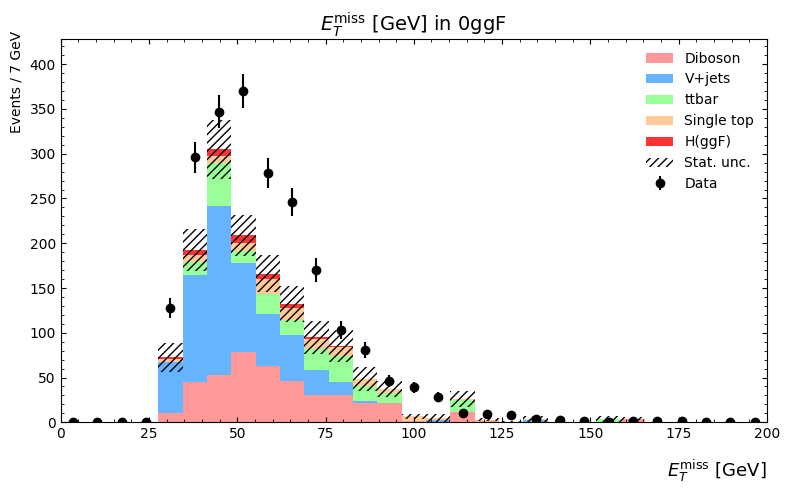

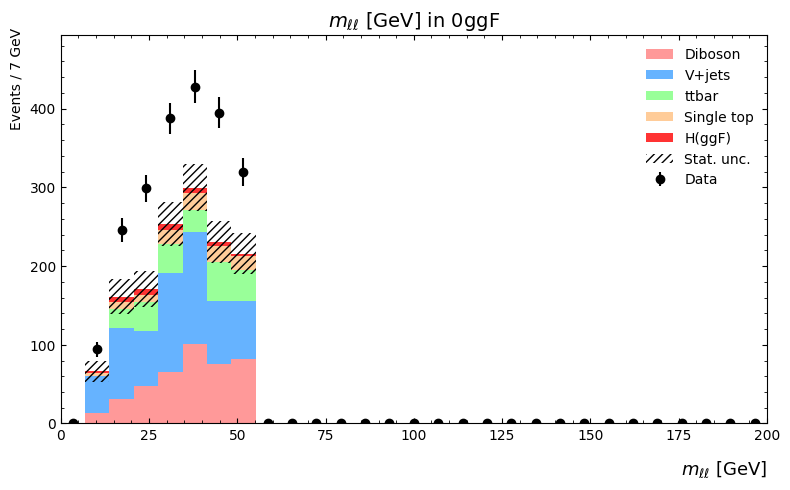

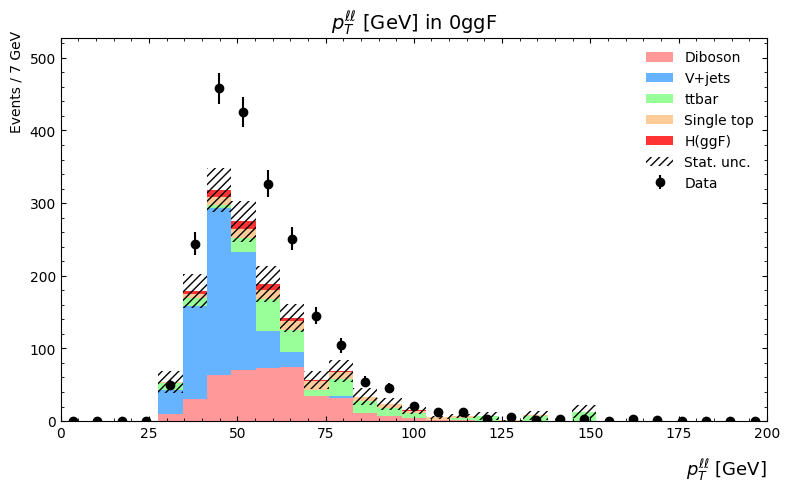

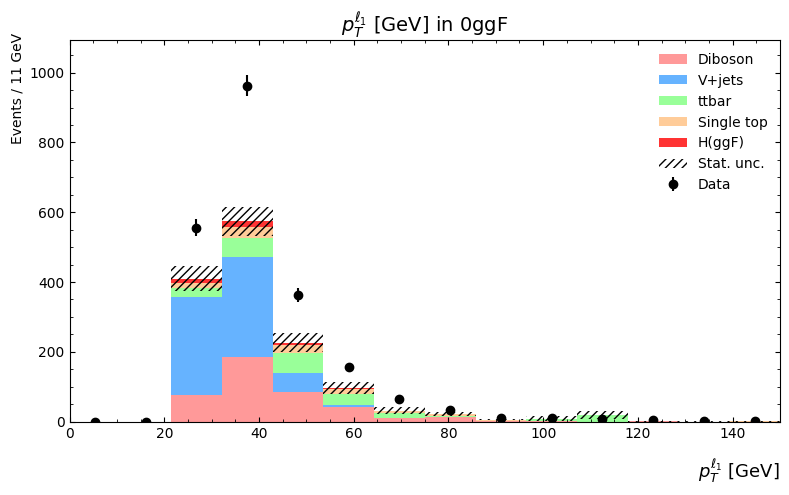

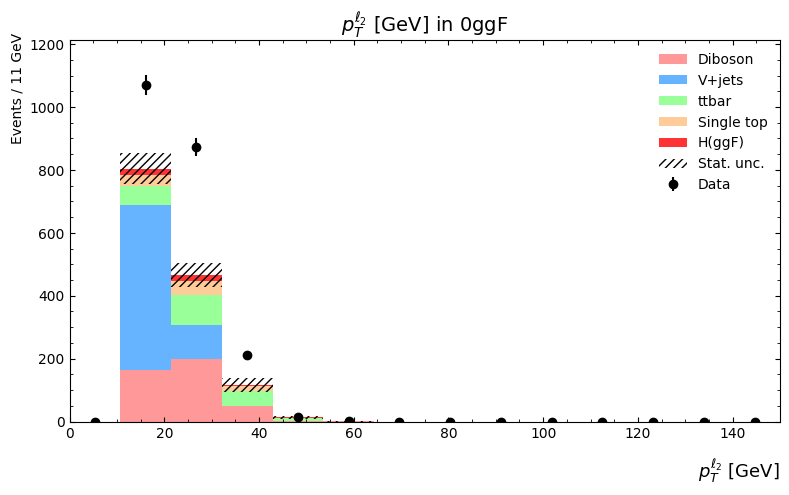


--- Channel: 1ggF ---


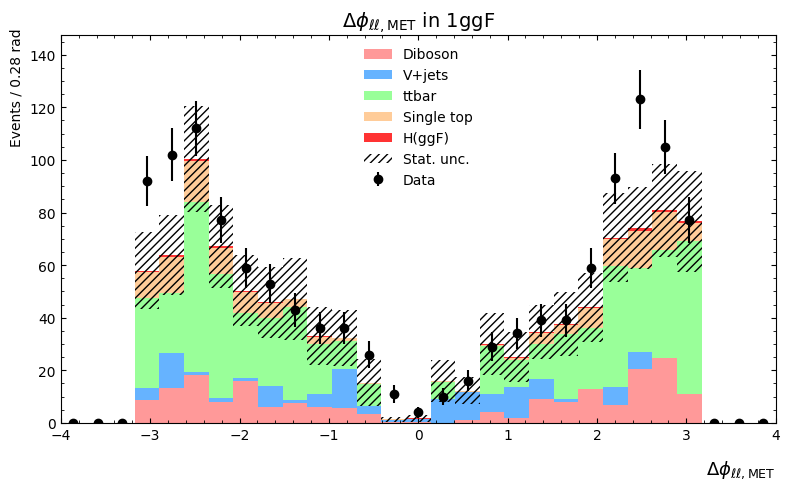

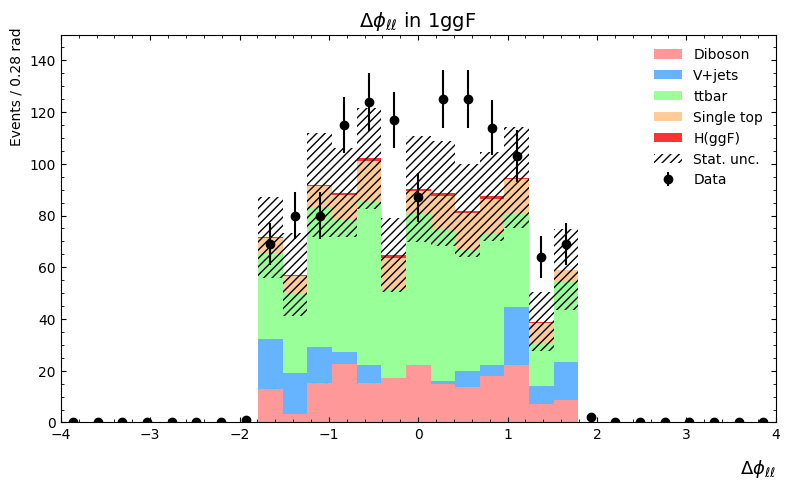

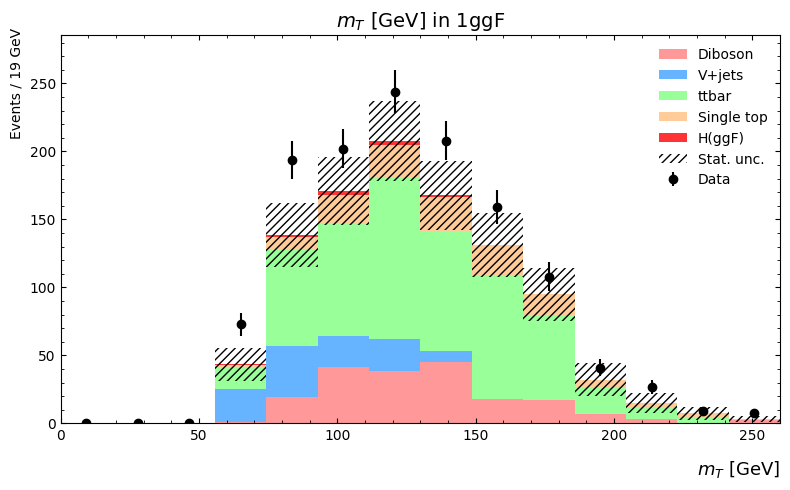

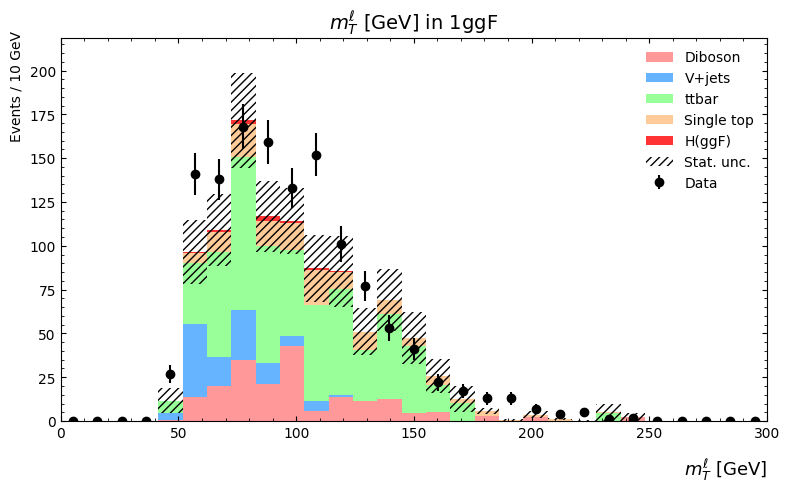

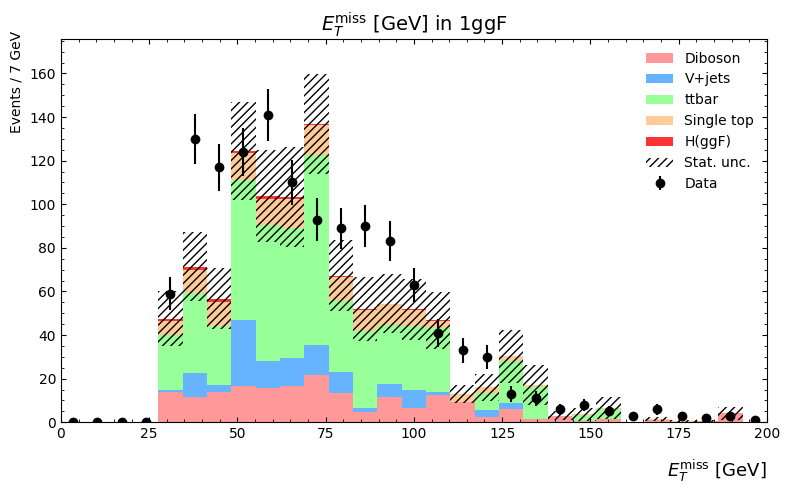

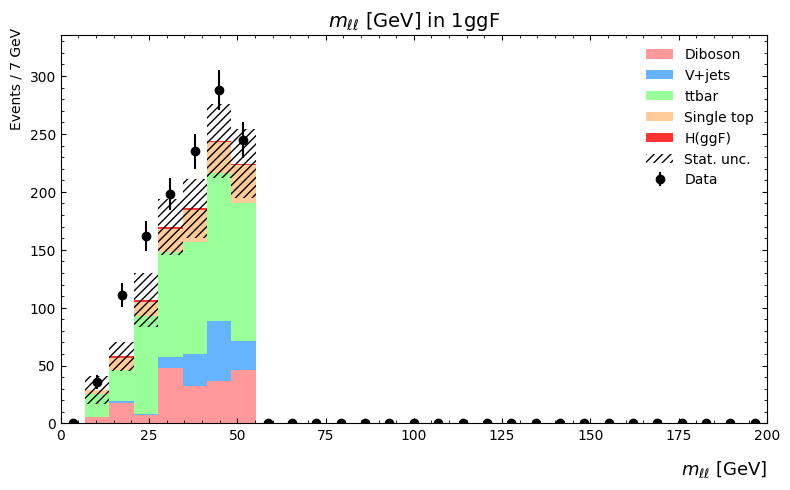

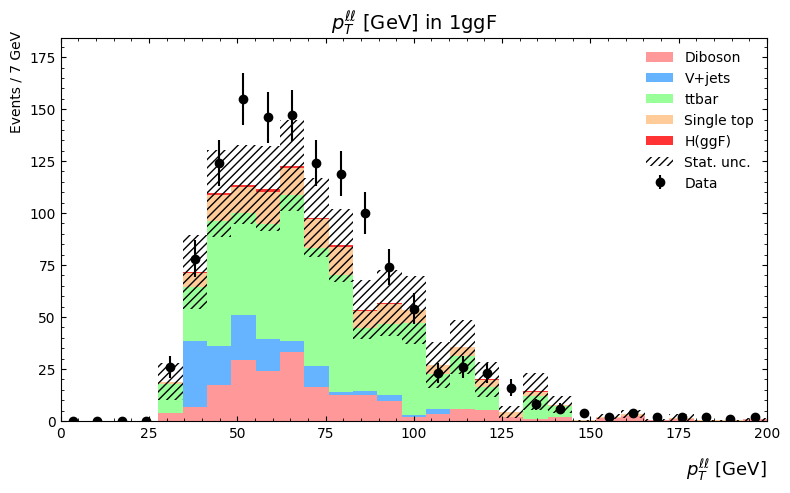

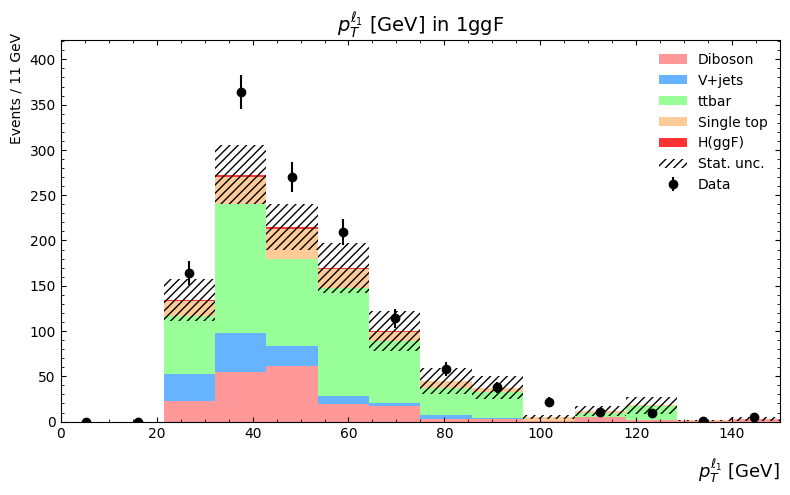

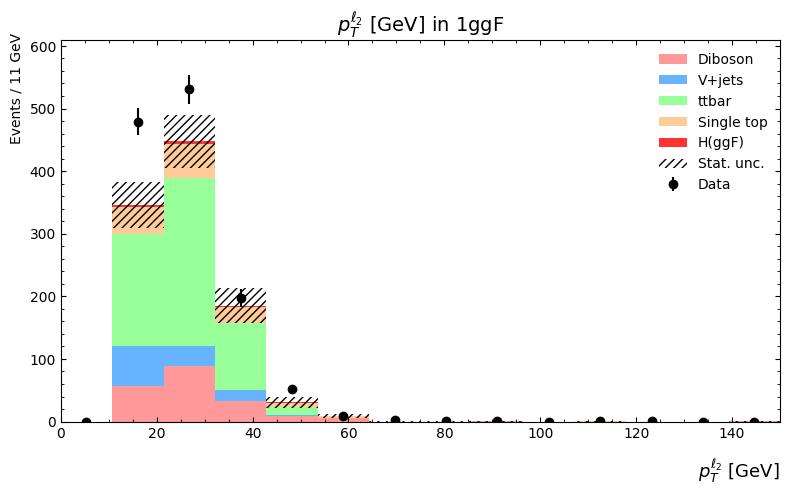

In [34]:
import os  
import json  
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import AutoMinorLocator  

channels = ["0ggF", '1ggF'] # VBF plotted separately 

selection_mode = "full"  # SR
json_dir = "background_json_by_selection_updated4"  # path to directory containing background json files
data_json_dir = "data_new_JSON"  # path to directory containing background json files

json_dir = "background_json_by_selection_test_FULL"  # mc files
data_json_dir = "data_json_by_selection_test_FULL"  # data files

variables_to_plot = {  # variables to plot - binning and labels
    "delta_phi_ll_met": {"xlabel": r"$\Delta\phi_{\ell\ell,\mathrm{MET}}$", "bins": np.linspace(-4, 4, 30)},
    "delta_phi_ll": {"xlabel": r"$\Delta\phi_{\ell\ell}$", "bins": np.linspace(-4, 4, 30)},
    "mT": {"xlabel": r"$m_T$ [GeV]", "bins": np.linspace(0, 260, 15), "scale": 1e-3}, #0 260, 15, 0, 300, 30
    "mT_ell": {"xlabel": r"$m_T^{\ell}$ [GeV]", "bins": np.linspace(0, 300, 30)},
    "met_et": {"xlabel": r"$E_T^{\mathrm{miss}}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "osof_mass": {"xlabel": r"$m_{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "pT_ll": {"xlabel": r"$p_T^{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "lep_pt_0": {"xlabel": r"$p_T^{\ell_1}$ [GeV]", "bins": np.linspace(0, 150, 15), "scale": 1e-3},
    "lep_pt_1": {"xlabel": r"$p_T^{\ell_2}$ [GeV]", "bins": np.linspace(0, 150, 15), "scale": 1e-3},
}

group_map = {  # map background groups to their categories
    "Diboson": ["diboson_leptonic", "diboson_semileptonic"],
    "V+jets": ["Wjets", "Zjets"], 
    "ttbar": ["top"],
    "Single top": ["top"],
    "H(ggF)": ["HWW"],
}

group_colors = {  # assign colors
    "Diboson": "#ff9999",
    "V+jets": "#66b3ff",
    "ttbar": "#99ff99",
    "Single top": "#ffcc99",
    "H(ggF)": "#ff3333",
}


ttbar_samples = ["ttbar_lep"]
single_top_samples = [
    'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan',
    'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan'
]

def load_mc_events(channel, cat, group_name):
    filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:  # open the json file for reading
        content = json.load(f)  # parse json content into a python dictionary
    events = []
    for sample_name, evts in content["samples"].items():
        if group_name == "ttbar" and sample_name not in ttbar_samples:
            continue
        if group_name == "Single top" and sample_name not in single_top_samples:
            continue
        if group_name == "H(ggF)" and sample_name != "ggH125_WW2lep":
            continue
        events.extend(evts)
    return events


def load_data_events(channel):
    filepath = os.path.join(data_json_dir, f"data_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:  # open the json file for reading
        content = json.load(f)  # json content into a python dictionary
    all_events = []
    for period_events in content["samples"].values():
        all_events.extend(period_events)
    return all_events

# main plotting
for channel in channels:  # loop over analysis channels
    print(f"\n--- Channel: {channel} ---")

    for var, meta in variables_to_plot.items():  # defining variables to plot, with binning and labels
        bin_edges = meta["bins"]
        step_size = bin_edges[1] - bin_edges[0]
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        xlabel = meta["xlabel"]
        scale = meta.get("scale", 1.0)

        fig, ax = plt.subplots(figsize=(8, 5)) 
        stack_vals, stack_wgts, stack_colors, stack_labels = [], [], [], []
        all_mc_vals, all_mc_weights = [], []

        for group_name, cats in group_map.items():  # map background groups to their component categories
            group_vals, group_wgts = [], []
            for cat in cats:
                events = load_mc_events(channel, cat, group_name)
                for evt in events:
                    if var.startswith("lep_pt") and "lep_pt" in evt:
                        i = int(var[-1])
                        leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                        if len(leptons_sorted) > i:
                            group_vals.append(leptons_sorted[i] * scale)
                            group_wgts.append(evt.get("weight", 1.0))
                    elif var in evt:
                        group_vals.append(evt[var] * scale)
                        group_wgts.append(evt.get("weight", 1.0))
            if group_vals:
                stack_vals.append(group_vals)
                stack_wgts.append(group_wgts)
                stack_colors.append(group_colors[group_name])  # assign colors to background groups for plotting
                stack_labels.append(group_name)
                all_mc_vals.append(group_vals)
                all_mc_weights.append(group_wgts)

        if stack_vals:
            ax.hist(stack_vals, bins=bin_edges, weights=stack_wgts,
                    stacked=True, color=stack_colors, label=stack_labels)

            flat_vals = np.hstack(all_mc_vals)
            flat_weights = np.hstack(all_mc_weights)
            mc_totals, _ = np.histogram(flat_vals, bins=bin_edges, weights=flat_weights)  # compute histogram values with weights
            mc_errors = np.sqrt(np.histogram(flat_vals, bins=bin_edges, weights=flat_weights**2)[0])  # compute histogram values with weights
            ax.bar(bin_centres, 2 * mc_errors, bottom=mc_totals - mc_errors,  # overlay statistical uncertainty as error bars
                   alpha=0.5, color='none', hatch="////", width=step_size,
                   label="Stat. unc.")

        #data
        data_vals = load_data_events(channel)
        data_var_vals = []
        for evt in data_vals:
            if var.startswith("lep_pt") and "lep_pt" in evt: # dealing with the two leptons
                i = int(var[-1])
                leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                if len(leptons_sorted) > i:
                    data_var_vals.append(leptons_sorted[i] * scale)
            elif var in evt: # things other than lepton variables
                data_var_vals.append(evt[var] * scale)

        # data and the errors
        data_counts, _ = np.histogram(data_var_vals, bins=bin_edges)
        data_errors = np.sqrt(data_counts)
        ax.errorbar(bin_centres, data_counts, yerr=data_errors,
                    fmt='ko', label='Data')

        # making the plot
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # set x-axis range
        ymax = max(max(mc_totals + mc_errors, default=0), max(data_counts + data_errors, default=0)) * 1.1
        ax.set_ylim(bottom=0, top=ymax)  # set y-axis lower and upper limits
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.set_xlabel(xlabel, fontsize=13, x=1, ha='right', labelpad=12)  # label the x-axis
        ylabel_unit = "GeV" if "GeV" in xlabel else "rad"
        step_label = f'{step_size:.0f}' if step_size >= 1 else f'{step_size:.2f}'
        ax.set_ylabel(f'Events / {step_label} {ylabel_unit}', y=1.02, ha='right')  # label the y-axis
        ax.legend(frameon=False) 
        ax.set_title(f"{xlabel} in {channel}", fontsize=14)  # set title for the plot
        plt.tight_layout()  
        plt.subplots_adjust(top=0.92)  
        plt.show() 

# ggF MC plots with scaled signal (no data)


--- Channel: 0ggF ---


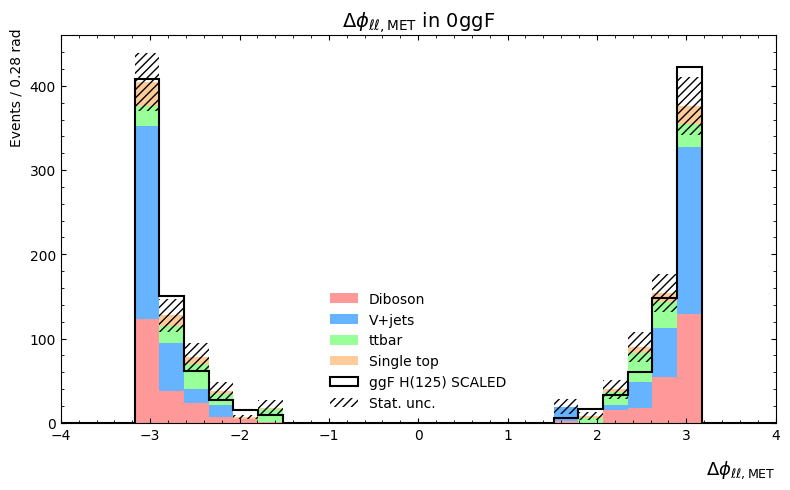

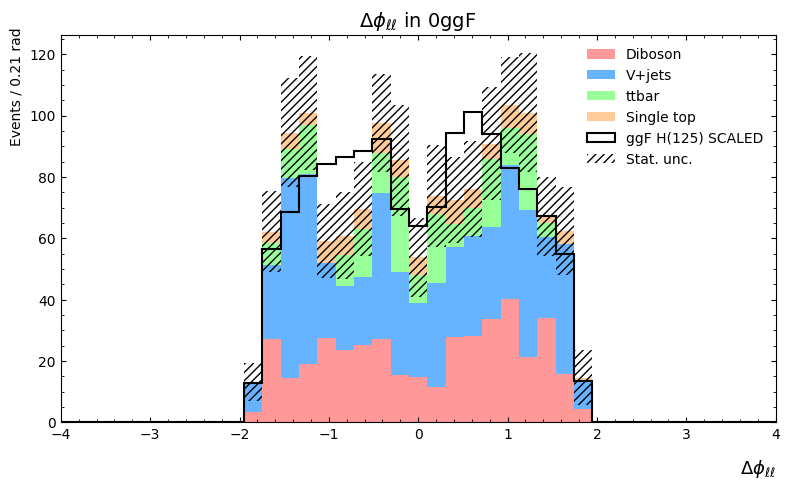

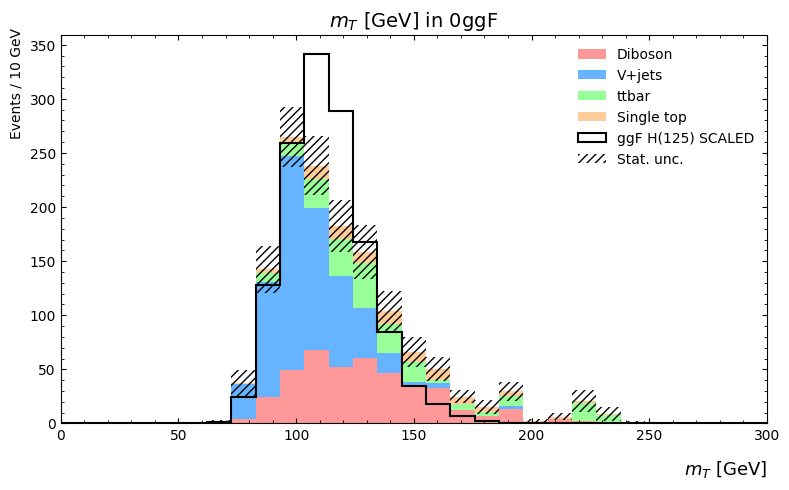

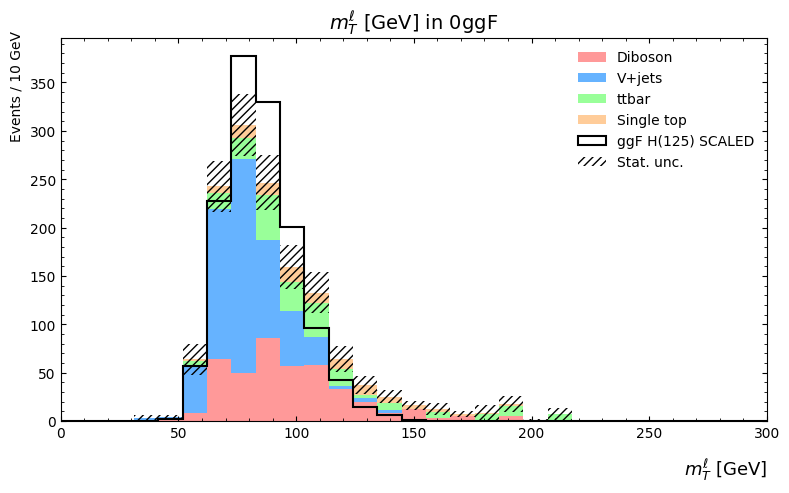

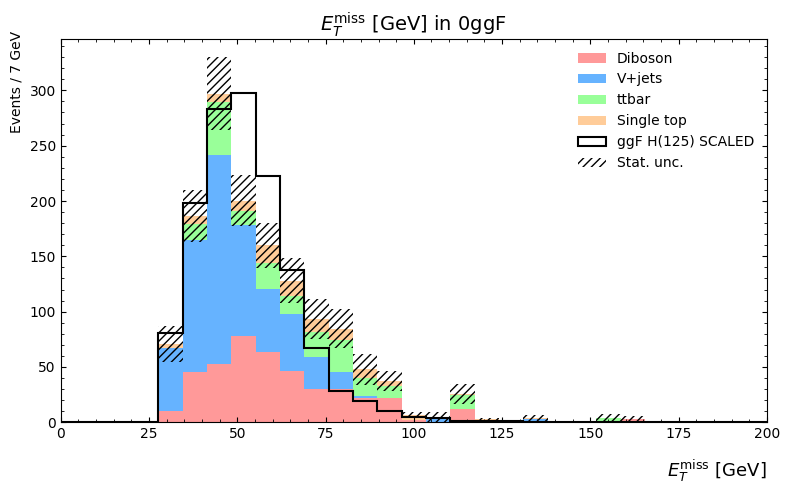

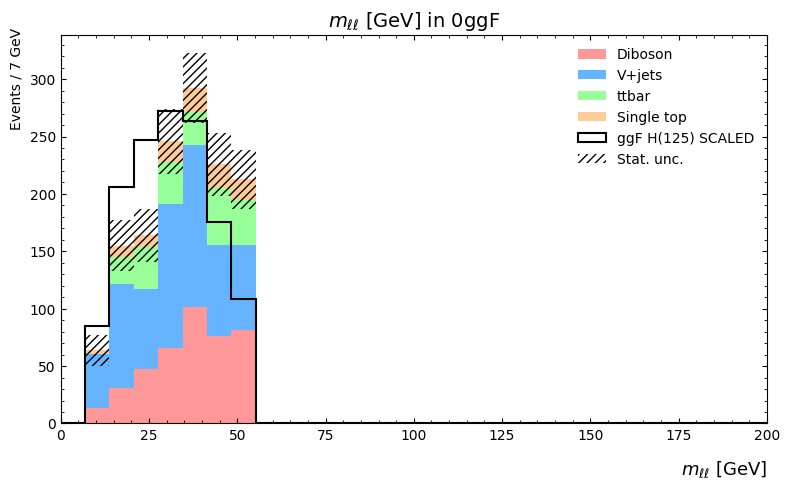

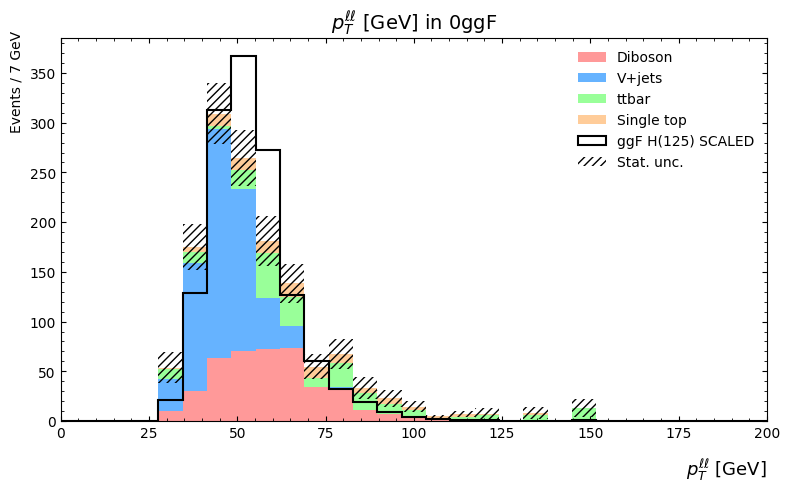

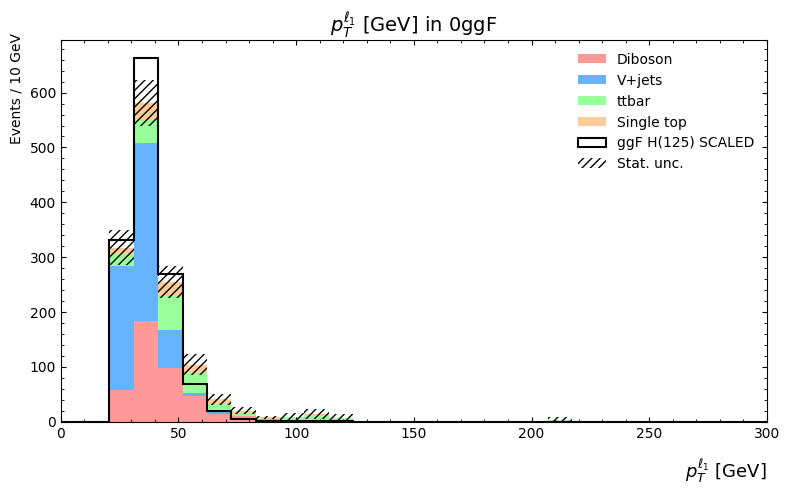

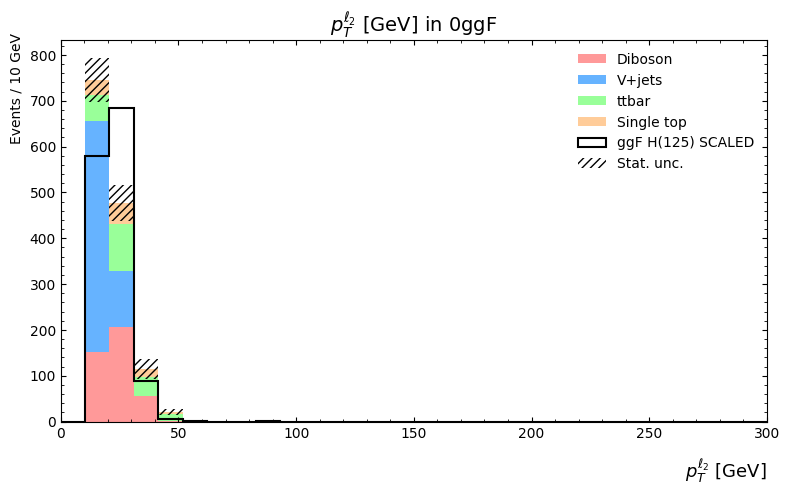


--- Channel: 1ggF ---


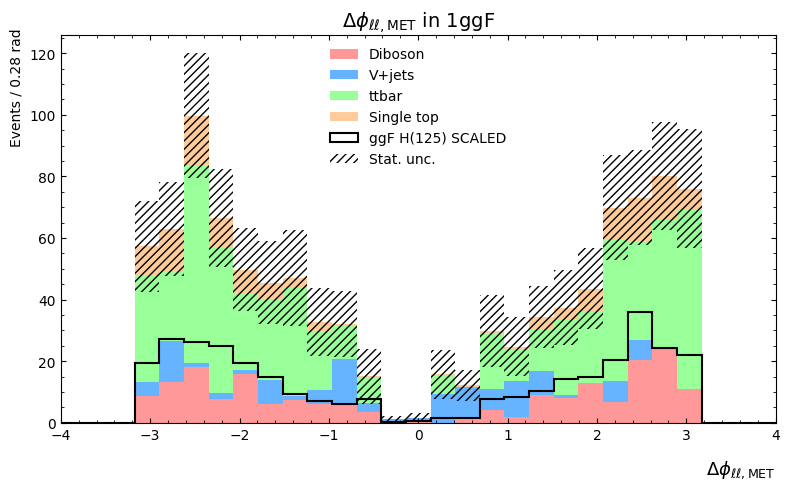

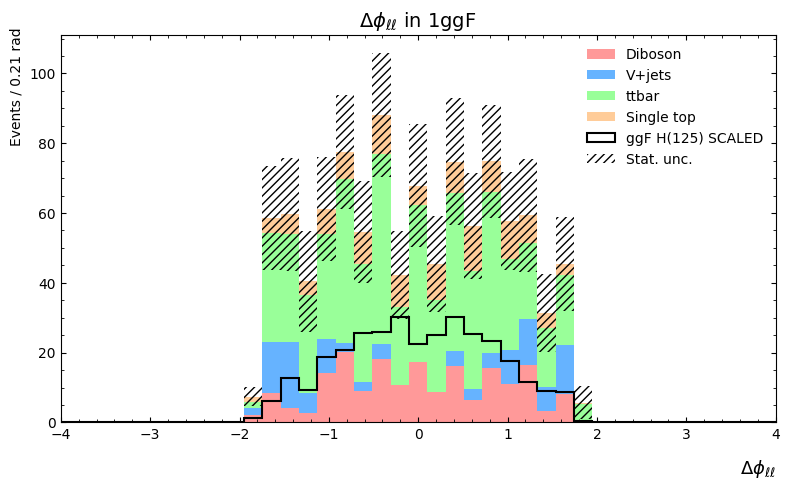

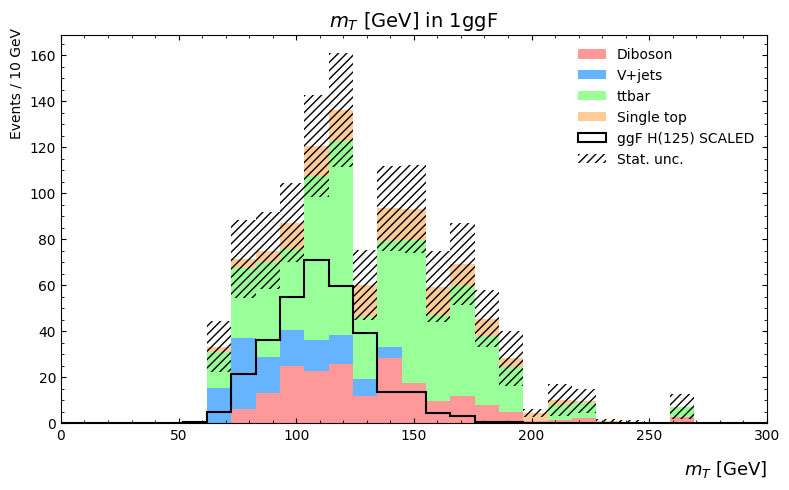

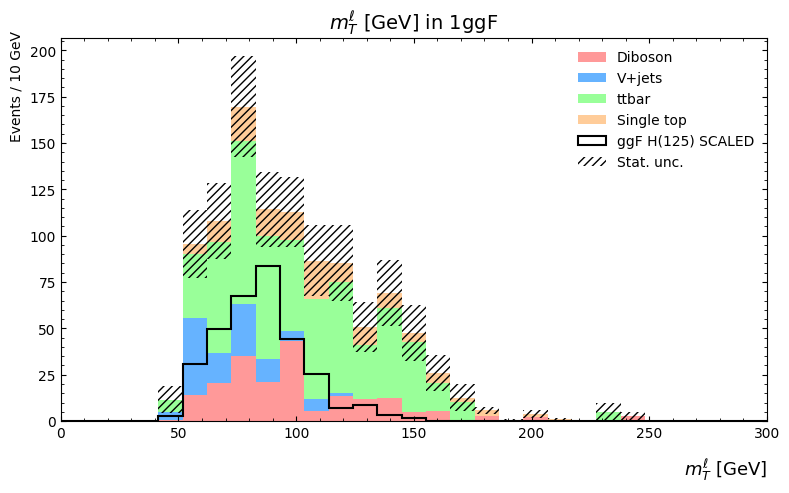

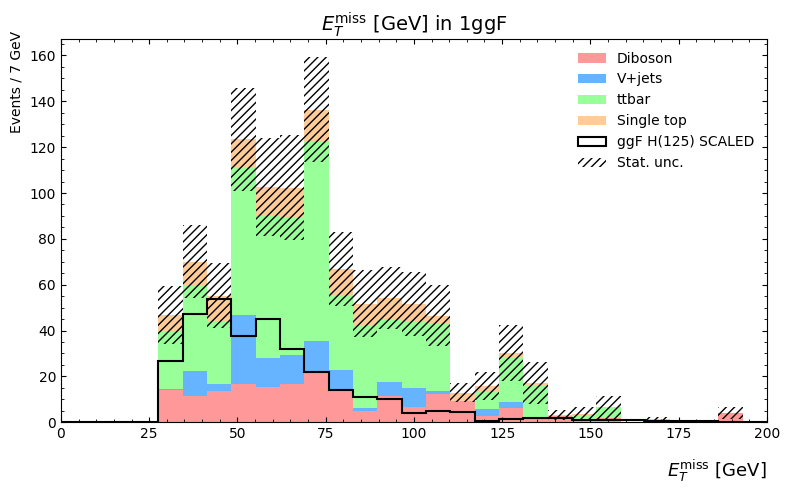

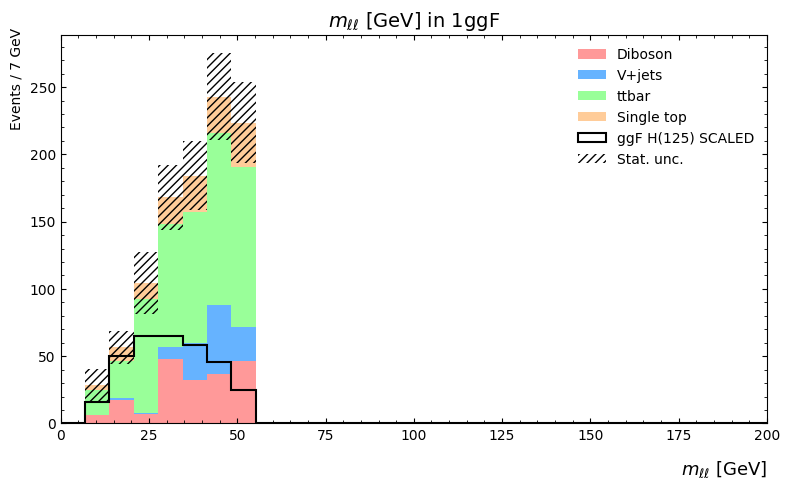

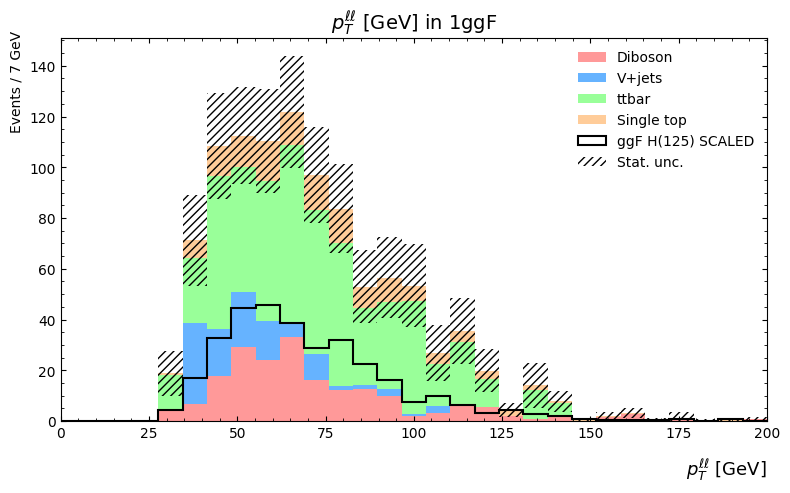

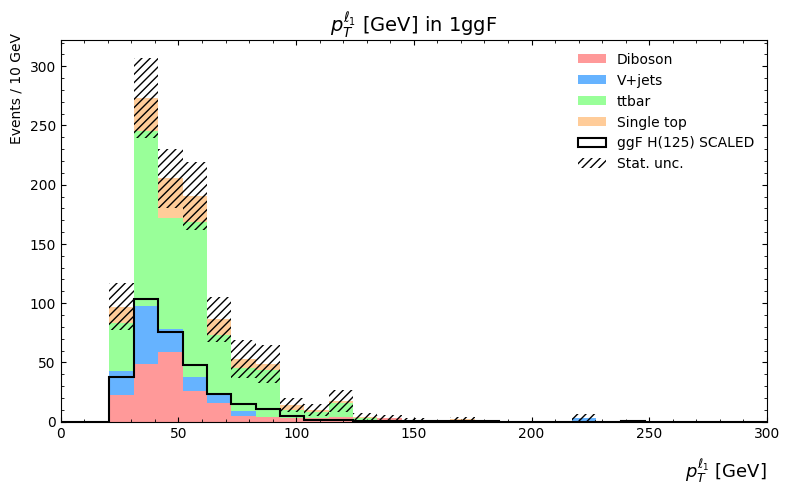

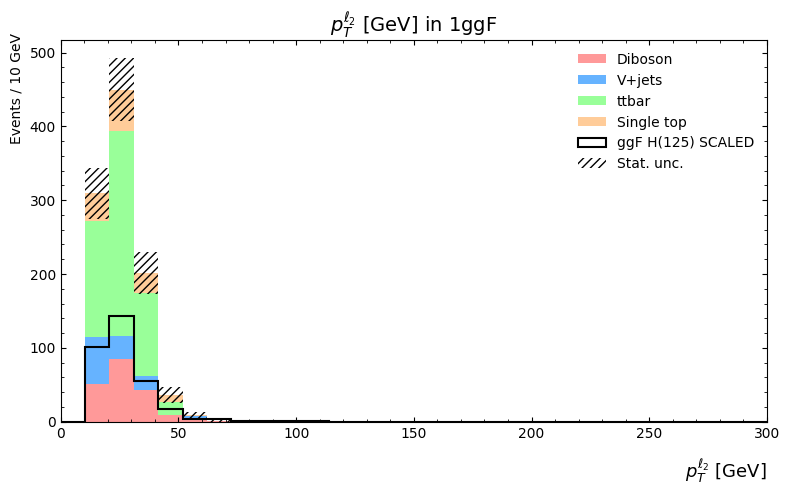

In [11]:

channels = ["0ggF", "1ggF"]  # define which analysis channel to process
selection_mode = "full"  # SR
json_dir = "background_json_by_selection_updated4" # json file
json_dir = "background_json_by_selection_test_FULL"  # mc files
signal_sample = "ggH125_WW2lep"
scale_signal = 35 # scale for comparions

variables_to_plot = {  # dictionary defining variables to plot
    "delta_phi_ll_met": {"xlabel": r"$\Delta\phi_{\ell\ell,\mathrm{MET}}$", "bins": np.linspace(-4, 4, 30)},
    "delta_phi_ll": {"xlabel": r"$\Delta\phi_{\ell\ell}$", "bins": np.linspace(-4, 4, 40)},
    "mT": {"xlabel": r"$m_T$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3}, # 0 260, 15, 0 300, 30
    "mT_ell": {"xlabel": r"$m_T^{\ell}$ [GeV]", "bins": np.linspace(0, 300, 30)},
    "met_et": {"xlabel": r"$E_T^{\mathrm{miss}}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "osof_mass": {"xlabel": r"$m_{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "pT_ll": {"xlabel": r"$p_T^{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "lep_pt_0": {"xlabel": r"$p_T^{\ell_1}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "lep_pt_1": {"xlabel": r"$p_T^{\ell_2}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
}

group_map = {  # map background groups
    "Diboson": ["diboson_leptonic", "diboson_semileptonic"],
    "V+jets": ["Zjets", "Wjets"],
    "ttbar": ["top"],
    "Single top": ["top"],
}

ttbar_samples = ["ttbar_lep"]
single_top_samples = [
    'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan',
    'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan'
]

group_colors = {  # assign colors
    "Diboson": "#ff9999",
    "V+jets": "#66b3ff",
    "ttbar": "#99ff99",
    "Single top": "#ffcc99"
}

def load_events(channel, cat, group_name):  # function to load background events from json file
    filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:  # open the json file for reading
        content = json.load(f)  # json content into a python dictionary
    events = []
    for sample_name, evts in content["samples"].items():
        if group_name == "ttbar" and sample_name not in ttbar_samples:
            continue
        if group_name == "Single top" and sample_name not in single_top_samples:
            continue
        events.extend(evts)
    return events

# plotting
for channel in channels:  # loop over analysis channels
    print(f"\n--- Channel: {channel} ---")

    for var, meta in variables_to_plot.items():  # dictionary defining variables to plot, with binning and labels
        bin_edges = meta["bins"]
        step_size = bin_edges[1] - bin_edges[0]
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        xlabel = meta["xlabel"]
        scale = meta.get("scale", 1.0)

        fig, ax = plt.subplots(figsize=(8, 5)) 

        stack_vals = []
        stack_wgts = []
        stack_colors = []
        stack_labels = []

        all_mc_vals = []
        all_mc_weights = []

        for group_name, cats in group_map.items():  # map background groups to their component categories
            group_vals, group_wgts = [], []
            for cat in cats:
                events = load_events(channel, cat, group_name)
                for evt in events:
                    if var.startswith("lep_pt") and "lep_pt" in evt: # for lepton variables
                        i = int(var[-1])
                        leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                        if len(leptons_sorted) > i:
                            group_vals.append(leptons_sorted[i] * scale)
                            group_wgts.append(evt.get("weight", 1.0))
                    elif var in evt: # for other variables
                        group_vals.append(evt[var] * scale)
                        group_wgts.append(evt.get("weight", 1.0))
            if group_vals:
                stack_vals.append(group_vals)
                stack_wgts.append(group_wgts)
                stack_colors.append(group_colors[group_name])  # assign colors to background groups for plotting
                stack_labels.append(group_name)
                all_mc_vals.append(group_vals)
                all_mc_weights.append(group_wgts)

        # mc stack
        ax.hist(all_mc_vals, bins=bin_edges, weights=all_mc_weights,
                stacked=True, color=stack_colors, label=stack_labels)

        # Stat uncertainty
        flat_vals = np.hstack(all_mc_vals)
        flat_weights = np.hstack(all_mc_weights)
        mc_totals, _ = np.histogram(flat_vals, bins=bin_edges, weights=flat_weights)  # compute histogram values with weights
        mc_errors = np.sqrt(np.histogram(flat_vals, bins=bin_edges, weights=flat_weights**2)[0])  # compute histogram values with weights
        ax.bar(bin_centres, 2 * mc_errors, bottom=mc_totals - mc_errors,  # overlay statistical uncertainty as error bars
               alpha=0.5, color='none', hatch="////", width=step_size,
               label="Stat. unc.")

        #Signal overlay
        sig_path = os.path.join(json_dir, f"HWW_{channel}_{selection_mode}.json")
        if os.path.exists(sig_path):
            with open(sig_path) as f:  # open the json file for reading
                content = json.load(f)  # json content into a python dictionary
            sig_events = content["samples"].get(signal_sample, [])
            sig_vals, sig_wgts = [], []
            for evt in sig_events:
                if var.startswith("lep_pt") and "lep_pt" in evt: # lepton variables
                    i = int(var[-1])
                    leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                    if len(leptons_sorted) > i:
                        sig_vals.append(leptons_sorted[i] * scale)
                        sig_wgts.append(evt["weight"] * scale_signal)
                elif var in evt: # other variables
                    sig_vals.append(evt[var] * scale)
                    sig_wgts.append(evt["weight"] * scale_signal)
            if sig_vals: # if there are events, plot them
                ax.hist(sig_vals, bins=bin_edges, weights=sig_wgts,
                        histtype="step", linewidth=1.5,
                        label="ggF H(125) SCALED", color="black")

        ax.set_xlim(bin_edges[0], bin_edges[-1])  # set x-axis range
        ax.set_ylim(bottom=0)  # set y-axis lower and upper limits
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.set_xlabel(xlabel, fontsize=13, x=1, ha='right', labelpad=12)  # label the x-axis
        ylabel_unit = "GeV" if "GeV" in xlabel else "rad"
        step_label = f'{step_size:.0f}' if step_size >= 1 else f'{step_size:.2f}'
        ax.set_ylabel(f'Events / {step_label} {ylabel_unit}', y=1.02, ha='right')  # label the y-axis
        ax.legend(frameon=False)  # show legend on plot
        ax.set_title(f"{xlabel} in {channel}", fontsize=14)
        plt.tight_layout() 
        plt.subplots_adjust(top=0.92) 
        plt.show()

# VBF SR plots (MC and data)


--- Channel: VBF ---


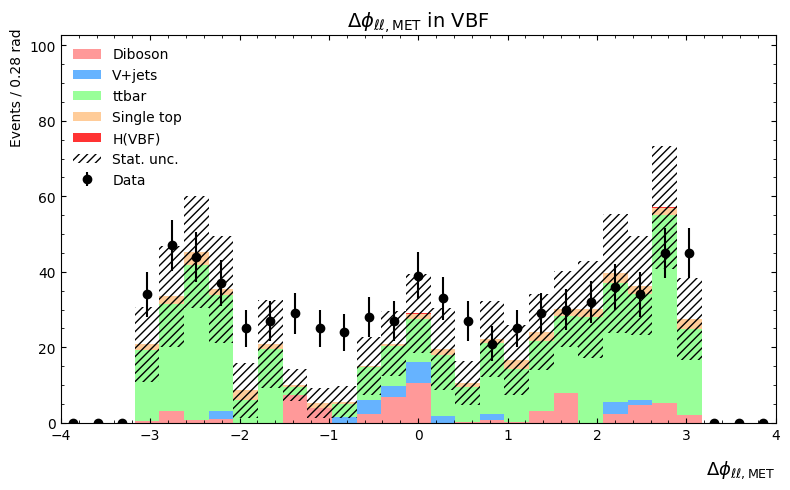

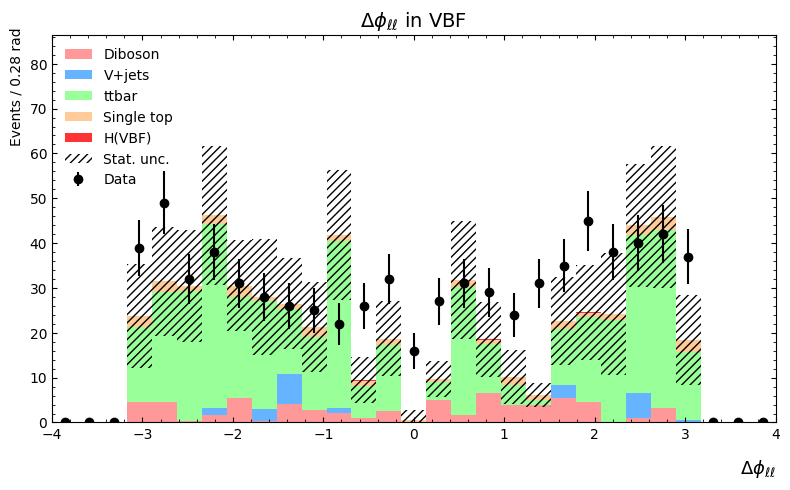

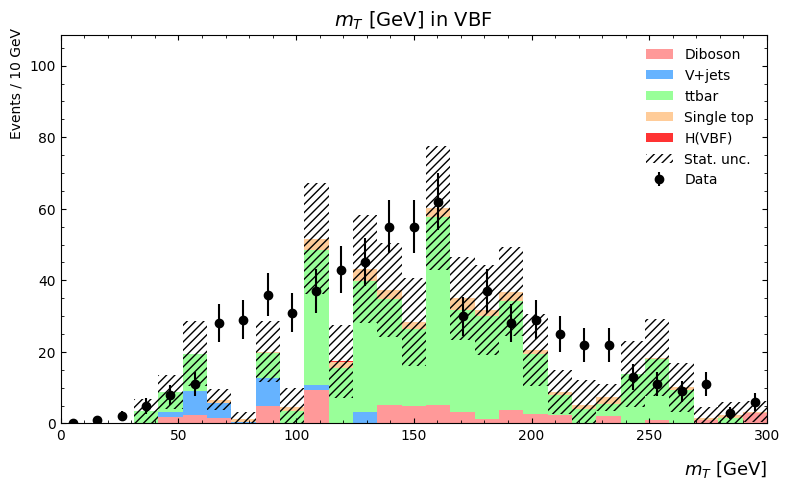

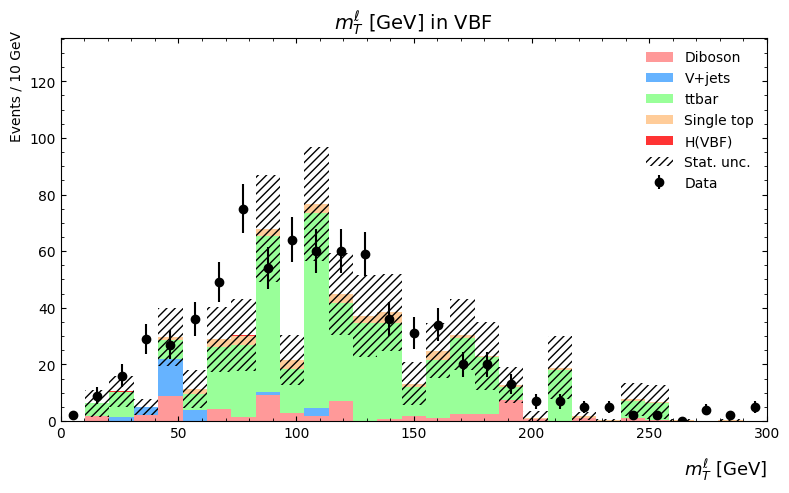

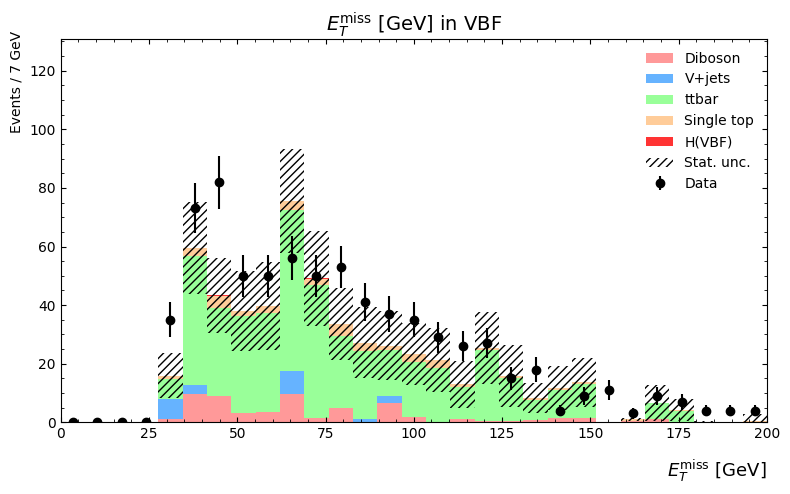

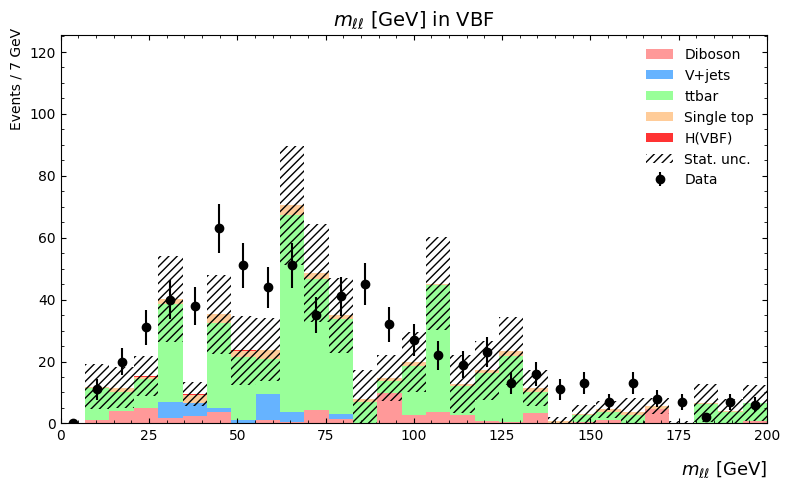

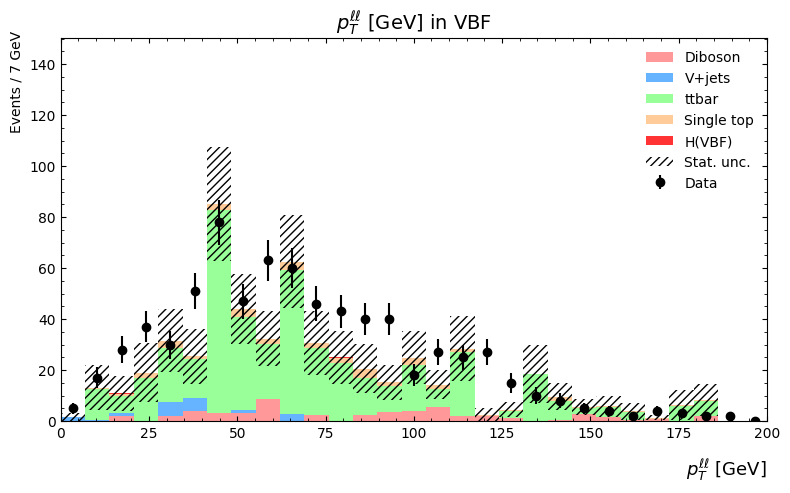

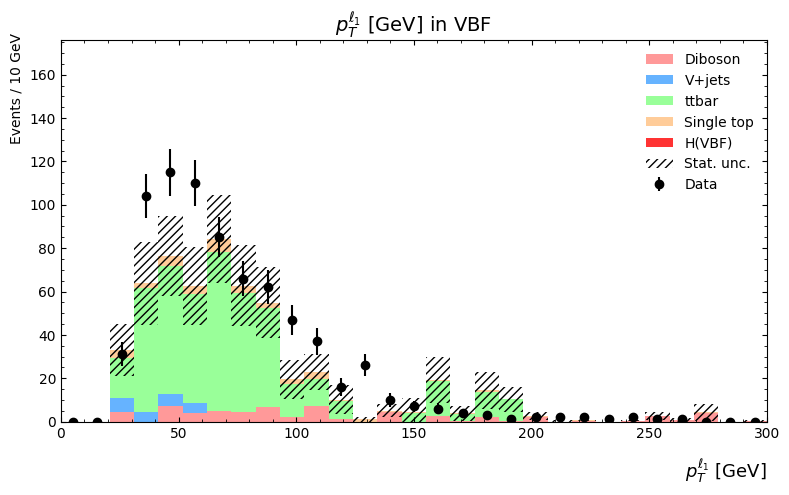

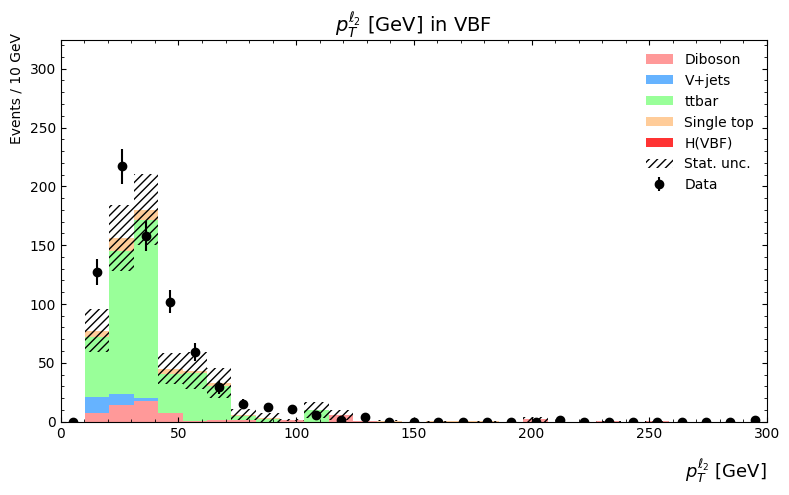

In [25]:
channels = ['VBF']  # VBF channel
selection_mode = "full"  # SR
json_dir = "background_json_by_selection_updated4"  # path to directory containing background json files
json_dir = "background_json_by_selection_test_FULL"  # mc files
data_json_dir = "data_new_JSON"  # path to directory containing background json files
data_json_dir = "data_json_by_selection_test_FULL"  # data files

variables_to_plot = {  # dictionary defining variables to plot, with binning and labels
    "delta_phi_ll_met": {"xlabel": r"$\Delta\phi_{\ell\ell,\mathrm{MET}}$", "bins": np.linspace(-4, 4, 30)},
    "delta_phi_ll": {"xlabel": r"$\Delta\phi_{\ell\ell}$", "bins": np.linspace(-4, 4, 30)},
    "mT": {"xlabel": r"$m_T$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "mT_ell": {"xlabel": r"$m_T^{\ell}$ [GeV]", "bins": np.linspace(0, 300, 30)},
    "met_et": {"xlabel": r"$E_T^{\mathrm{miss}}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "osof_mass": {"xlabel": r"$m_{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "pT_ll": {"xlabel": r"$p_T^{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "lep_pt_0": {"xlabel": r"$p_T^{\ell_1}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "lep_pt_1": {"xlabel": r"$p_T^{\ell_2}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
}


group_map = {  # map background groups
    "Diboson": ["diboson_leptonic", "diboson_semileptonic"],
    "V+jets": ["Wjets", "Zjets"], 
    "ttbar": ["top"],
    "Single top": ["top"],
    "H(VBF)": ["HWW"],
}

group_colors = {  # assign colors 
    "Diboson": "#ff9999",
    "V+jets": "#66b3ff",
    "ttbar": "#99ff99",
    "Single top": "#ffcc99",
    "H(VBF)": "#ff3333",
}


ttbar_samples = ["ttbar_lep"]
single_top_samples = [
    'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan',
    'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan'
]

def load_mc_events(channel, cat, group_name):
    filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:  # open the json file for reading
        content = json.load(f)  # json content into a python dictionary
    events = []
    for sample_name, evts in content["samples"].items():
        if group_name == "ttbar" and sample_name not in ttbar_samples:
            continue
        if group_name == "Single top" and sample_name not in single_top_samples:
            continue
        if group_name == "H(VBF)" and sample_name != "VBFH125_WW2lep":
            continue
        events.extend(evts)
    return events


def load_data_events(channel):
    filepath = os.path.join(data_json_dir, f"data_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:  # open the json file for reading
        content = json.load(f)  # json content into a python dictionary
    all_events = []
    for period_events in content["samples"].values():
        all_events.extend(period_events)
    return all_events

# main loop
for channel in channels:  # loop over analysis channels
    print(f"\n--- Channel: {channel} ---")

    for var, meta in variables_to_plot.items():  # dictionary defining variables to plot
        bin_edges = meta["bins"]
        step_size = bin_edges[1] - bin_edges[0]
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        xlabel = meta["xlabel"]
        scale = meta.get("scale", 1.0)

        fig, ax = plt.subplots(figsize=(8, 5)) 
        stack_vals, stack_wgts, stack_colors, stack_labels = [], [], [], []
        all_mc_vals, all_mc_weights = [], []

        for group_name, cats in group_map.items():  # map background groups to their component categories
            group_vals, group_wgts = [], []
            for cat in cats:
                events = load_mc_events(channel, cat, group_name)
                for evt in events:
                    if var.startswith("lep_pt") and "lep_pt" in evt:
                        i = int(var[-1])
                        leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                        if len(leptons_sorted) > i:
                            group_vals.append(leptons_sorted[i] * scale)
                            group_wgts.append(evt.get("weight", 1.0))
                    elif var in evt:
                        group_vals.append(evt[var] * scale)
                        group_wgts.append(evt.get("weight", 1.0))
            if group_vals:
                stack_vals.append(group_vals)
                stack_wgts.append(group_wgts)
                stack_colors.append(group_colors[group_name])  # assign colors to background groups for plotting
                stack_labels.append(group_name)
                all_mc_vals.append(group_vals)
                all_mc_weights.append(group_wgts)
        # if non empty
        if stack_vals:
            ax.hist(stack_vals, bins=bin_edges, weights=stack_wgts,
                    stacked=True, color=stack_colors, label=stack_labels)
            # errors
            flat_vals = np.hstack(all_mc_vals)
            flat_weights = np.hstack(all_mc_weights)
            mc_totals, _ = np.histogram(flat_vals, bins=bin_edges, weights=flat_weights)  # compute histogram values with weights
            mc_errors = np.sqrt(np.histogram(flat_vals, bins=bin_edges, weights=flat_weights**2)[0])  # compute histogram values with weights
            ax.bar(bin_centres, 2 * mc_errors, bottom=mc_totals - mc_errors,  # overlay statistical uncertainty as error bars
                   alpha=0.5, color='none', hatch="////", width=step_size,
                   label="Stat. unc.")

        # data
        data_vals = load_data_events(channel)
        data_var_vals = []
        for evt in data_vals:
            if var.startswith("lep_pt") and "lep_pt" in evt: # lepton variables
                i = int(var[-1])
                leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                if len(leptons_sorted) > i:
                    data_var_vals.append(leptons_sorted[i] * scale)
            elif var in evt: # other variables
                data_var_vals.append(evt[var] * scale)

        # plotting the data
        data_counts, _ = np.histogram(data_var_vals, bins=bin_edges)
        data_errors = np.sqrt(data_counts)
        ax.errorbar(bin_centres, data_counts, yerr=data_errors,
                    fmt='ko', label='Data')

        # plot design
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # set x-axis range
        ymax = max(max(mc_totals + mc_errors, default=0), max(data_counts + data_errors, default=0)) * 1.4
        ax.set_ylim(bottom=0, top=ymax)  # set y-axis lower and upper limits
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.set_xlabel(xlabel, fontsize=13, x=1, ha='right', labelpad=12)  # label the x-axis
        ylabel_unit = "GeV" if "GeV" in xlabel else "rad"
        step_label = f'{step_size:.0f}' if step_size >= 1 else f'{step_size:.2f}'
        ax.set_ylabel(f'Events / {step_label} {ylabel_unit}', y=1.02, ha='right')  # label the y-axis
        ax.legend(frameon=False)  # show legend on plot
        ax.set_title(f"{xlabel} in {channel}", fontsize=14)  # set title for the plot
        plt.tight_layout() 
        plt.subplots_adjust(top=0.92) 
        plt.show()

# VBF plots with scaled signal


--- Channel: VBF ---


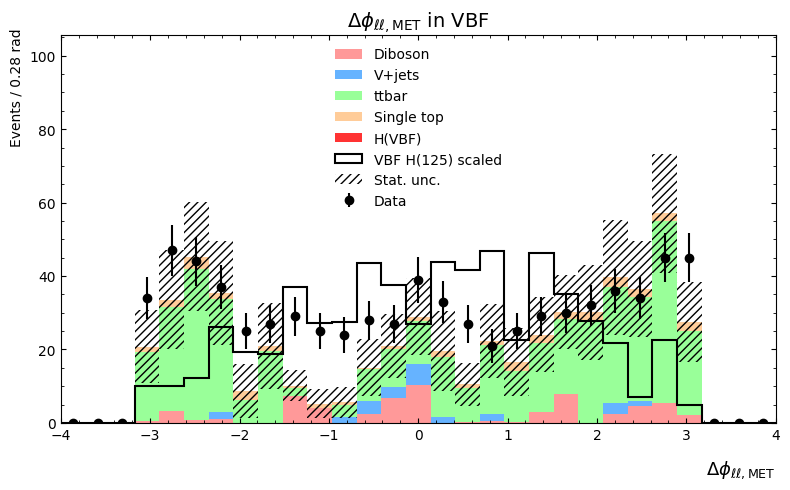

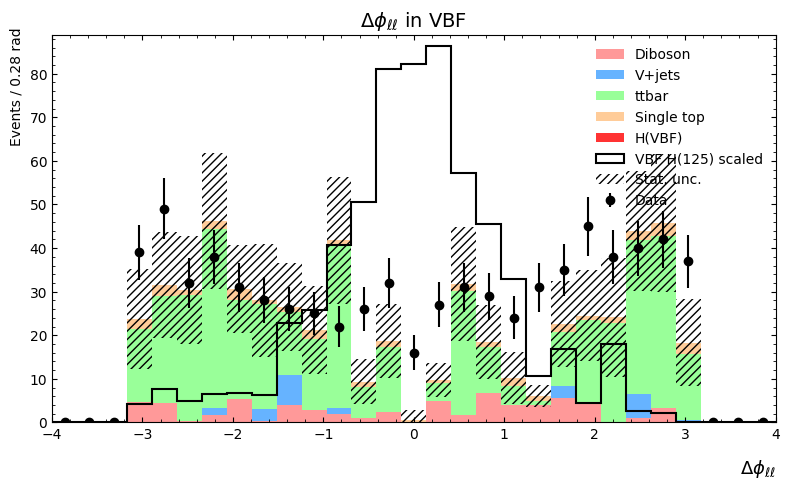

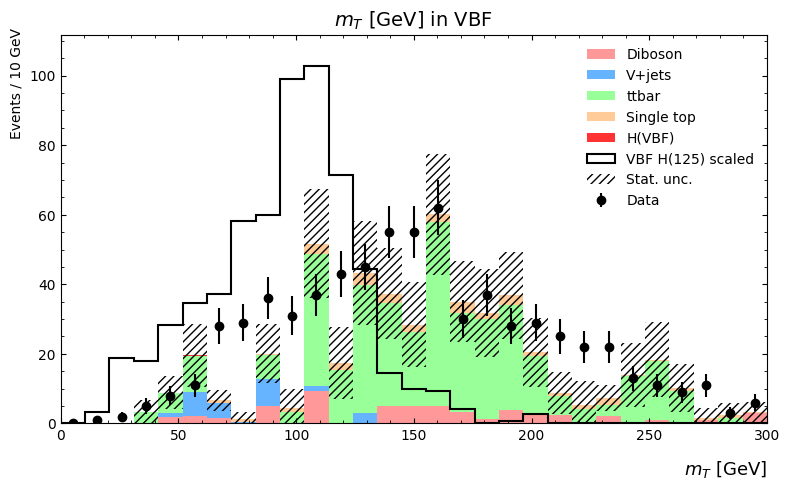

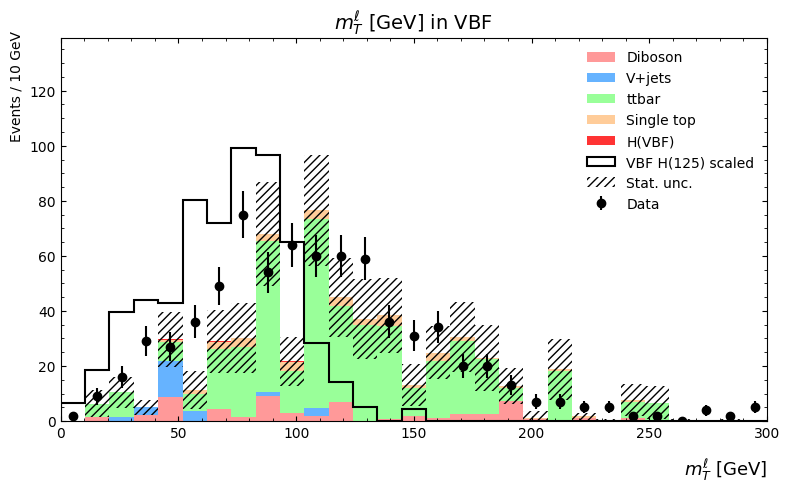

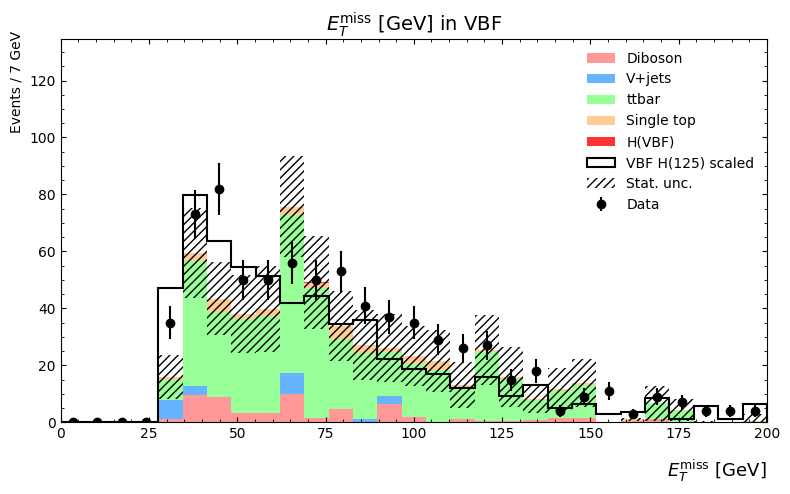

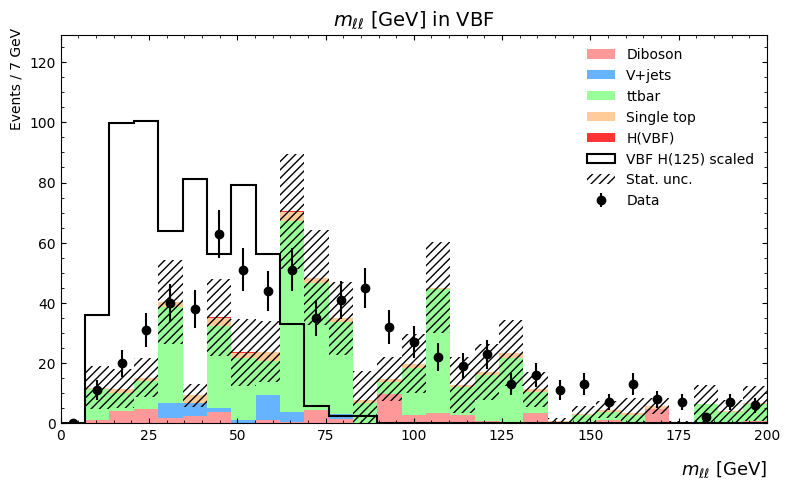

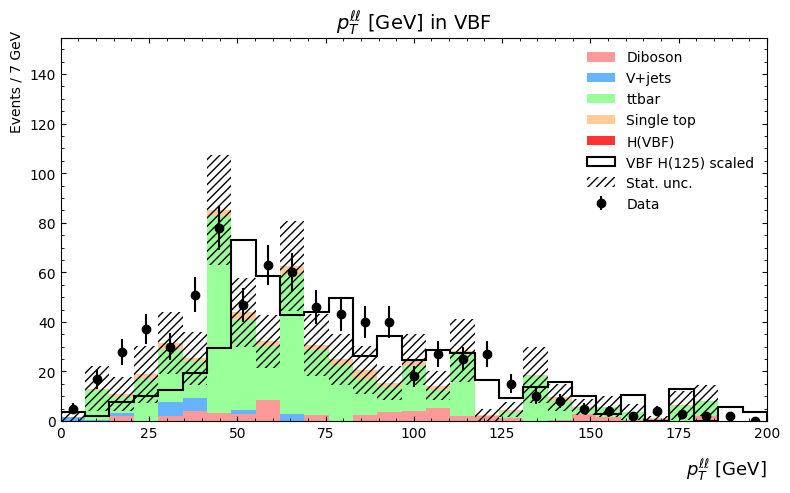

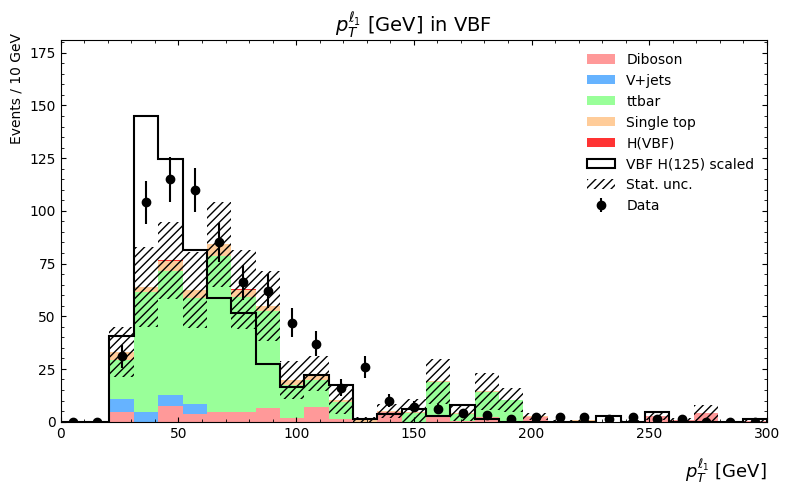

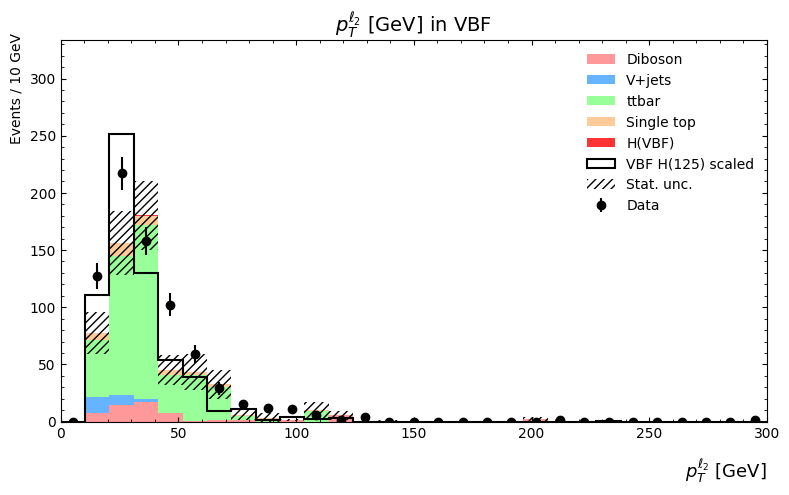

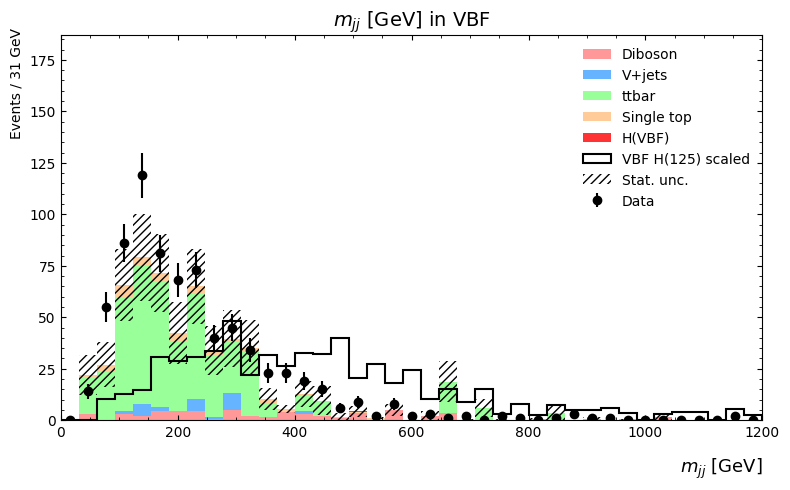

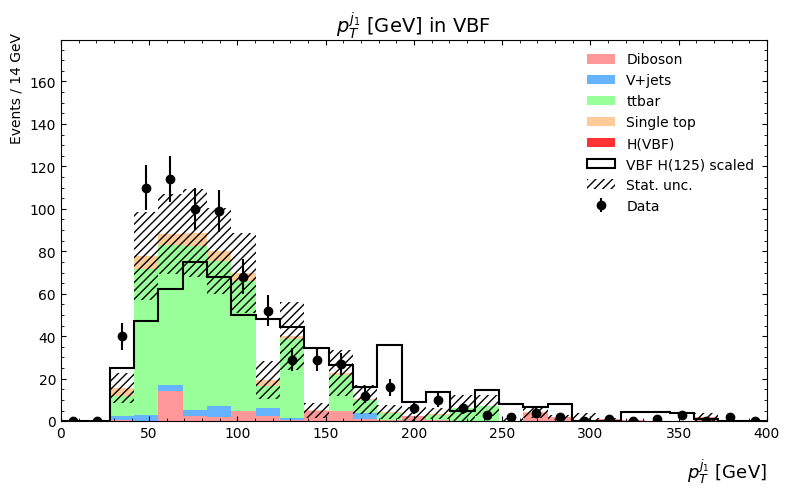

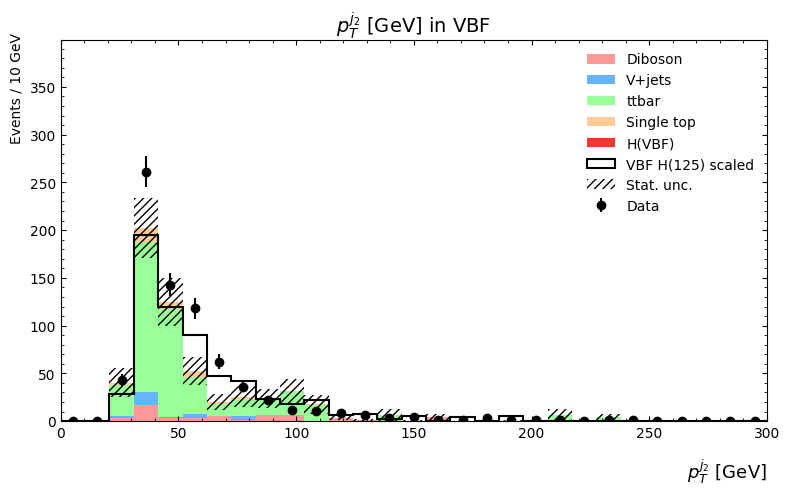

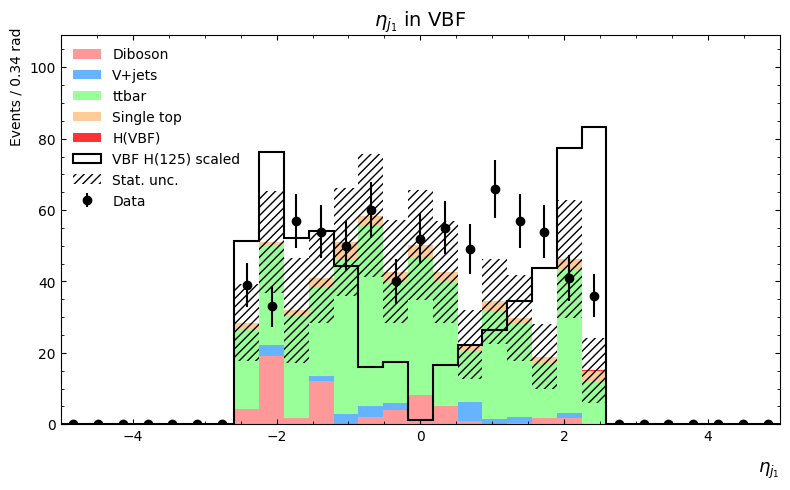

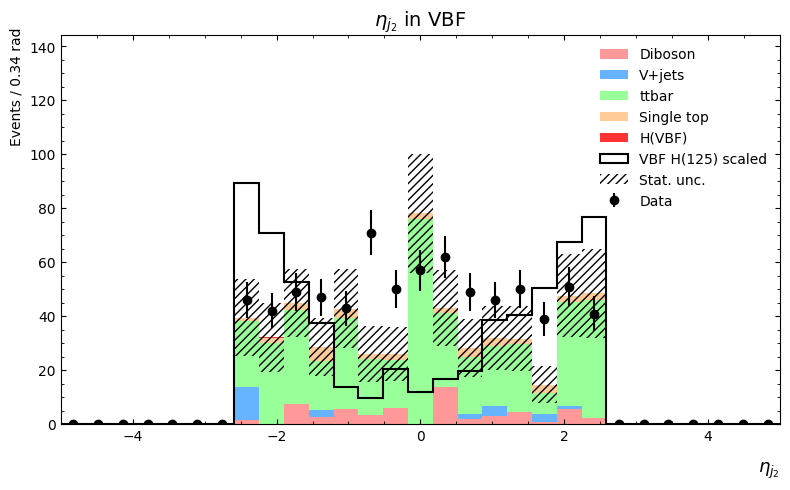

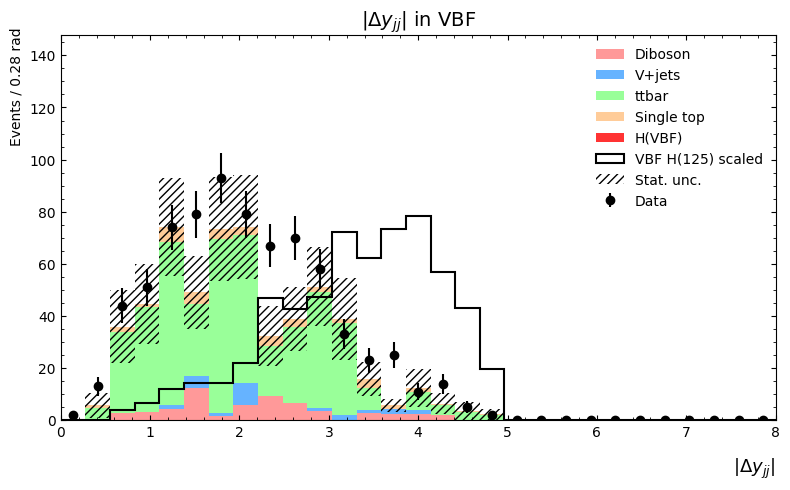

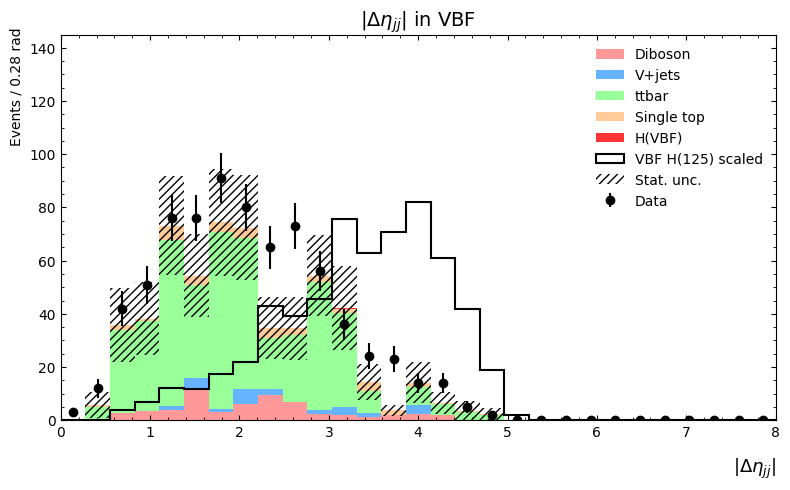

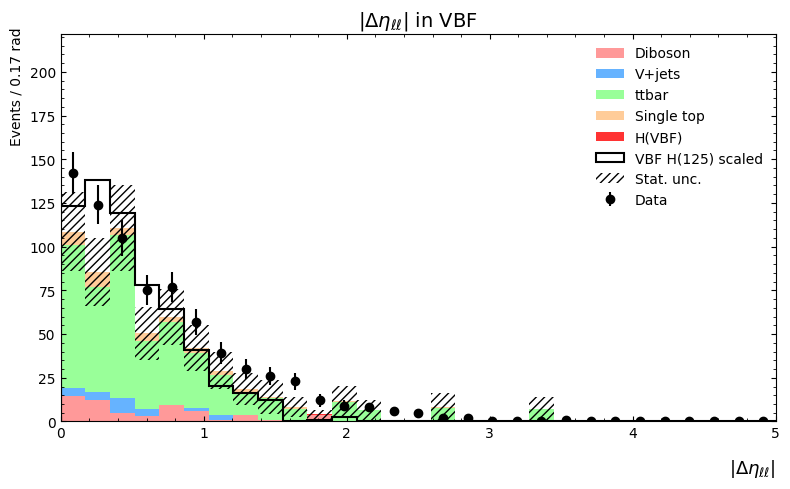

In [36]:
channels = ['VBF']  # VBF channel
selection_mode = "full"  # SR
#json_dir = "background_json_by_selection_updated4"  # path to directory containing background json files
json_dir = "background_json_by_selection_test_FULL"  # mc files
#data_json_dir = "data_new_JSON"  # path to directory containing background json files
data_json_dir = "data_json_by_selection_test_FULL"  # data files

variables_to_plot = {  # dictionary defining variables to plot
    "delta_phi_ll_met": {"xlabel": r"$\Delta\phi_{\ell\ell,\mathrm{MET}}$", "bins": np.linspace(-4, 4, 30)},
    "delta_phi_ll": {"xlabel": r"$\Delta\phi_{\ell\ell}$", "bins": np.linspace(-4, 4, 30)},
    "mT": {"xlabel": r"$m_T$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "mT_ell": {"xlabel": r"$m_T^{\ell}$ [GeV]", "bins": np.linspace(0, 300, 30)},
    "met_et": {"xlabel": r"$E_T^{\mathrm{miss}}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "osof_mass": {"xlabel": r"$m_{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "pT_ll": {"xlabel": r"$p_T^{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "lep_pt_0": {"xlabel": r"$p_T^{\ell_1}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "lep_pt_1": {"xlabel": r"$p_T^{\ell_2}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "mjj": {"xlabel": r"$m_{jj}$ [GeV]", "bins": np.linspace(0, 1200, 40), "scale": 1e-3},
    "jet_pt_0": {"xlabel": r"$p_T^{j_1}$ [GeV]", "bins": np.linspace(0, 400, 30), "scale": 1e-3},
    "jet_pt_1": {"xlabel": r"$p_T^{j_2}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "jet_eta_0": {"xlabel": r"$\eta_{j_1}$", "bins": np.linspace(-5, 5, 30)},
    "jet_eta_1": {"xlabel": r"$\eta_{j_2}$", "bins": np.linspace(-5, 5, 30)},
    "delta_y_jj": {"xlabel": r"$|\Delta y_{jj}|$", "bins": np.linspace(0, 8, 30)},
    "delta_eta_jj": {"xlabel": r"$|\Delta \eta_{jj}|$", "bins": np.linspace(0, 8, 30)},
    "delta_eta_ll": {"xlabel": r"$|\Delta \eta_{\ell\ell}|$", "bins": np.linspace(0, 5, 30)},
}

group_map = {  # map background groups
    "Diboson": ["diboson_leptonic", "diboson_semileptonic"],
    "V+jets": ["Wjets", "Zjets"], 
    "ttbar": ["top"],
    "Single top": ["top"],
    "H(VBF)": ["HWW"],
}

group_colors = {  # assign colors
    "Diboson": "#ff9999",
    "V+jets": "#66b3ff",
    "ttbar": "#99ff99",
    "Single top": "#ffcc99",
    "H(VBF)": "#ff3333",
}

ttbar_samples = ["ttbar_lep"]
single_top_samples = [
    'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan',
    'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan'
]

def load_mc_events(channel, cat, group_name):
    filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:  # open the json file for reading
        content = json.load(f)  # json content into a python dictionary
    events = []
    for sample_name, evts in content["samples"].items():
        if group_name == "ttbar" and sample_name not in ttbar_samples:
            continue
        if group_name == "Single top" and sample_name not in single_top_samples:
            continue
        if group_name == "H(VBF)" and sample_name != "VBFH125_WW2lep":
            continue
        events.extend(evts)
    return events

def load_data_events(channel):
    filepath = os.path.join(data_json_dir, f"data_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:  # open the json file for reading
        content = json.load(f)  # json content into a python dictionary
    all_events = []
    for period_events in content["samples"].values():
        all_events.extend(period_events)
    return all_events

# for comptuing these specific quantities
# delta eta
def delta_eta(obj_eta):
    return abs(obj_eta[0] - obj_eta[1]) if len(obj_eta) >= 2 else np.nan
# difference in rapidity
def delta_y_jj(evt):
    idx = np.argsort(evt["jet_pt"])[::-1]
    y1 = 0.5 * np.log((evt["jet_E"][idx[0]] + evt["jet_pt"][idx[0]] * np.sinh(evt["jet_eta"][idx[0]])) /
                     (evt["jet_E"][idx[0]] - evt["jet_pt"][idx[0]] * np.sinh(evt["jet_eta"][idx[0]])))
    y2 = 0.5 * np.log((evt["jet_E"][idx[1]] + evt["jet_pt"][idx[1]] * np.sinh(evt["jet_eta"][idx[1]])) /
                     (evt["jet_E"][idx[1]] - evt["jet_pt"][idx[1]] * np.sinh(evt["jet_eta"][idx[1]])))
    return abs(y1 - y2)

# main loop
for channel in channels:  # loop over analysis channels
    print(f"\n--- Channel: {channel} ---")
    for var, meta in variables_to_plot.items():  # dictionary defining variables to plot
        bin_edges = meta["bins"]
        step_size = bin_edges[1] - bin_edges[0]
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        xlabel = meta["xlabel"]
        scale = meta.get("scale", 1.0)

        fig, ax = plt.subplots(figsize=(8, 5))  # figure
        stack_vals, stack_wgts, stack_colors, stack_labels = [], [], [], []
        all_mc_vals, all_mc_weights = [], []

        for group_name, cats in group_map.items():  # map background groups to their component categories
            group_vals, group_wgts = [], []
            for cat in cats:
                events = load_mc_events(channel, cat, group_name)
                for evt in events:
                    if var.startswith("lep_pt") and "lep_pt" in evt: # for lepton variables
                        i = int(var[-1])
                        leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                        if len(leptons_sorted) > i:
                            group_vals.append(leptons_sorted[i] * scale)
                            group_wgts.append(evt.get("weight", 1.0))
                    elif var.startswith("jet_pt") or var.startswith("jet_eta"): # for the jet variables
                        i = int(var[-1])
                        key = "jet_pt" if "pt" in var else "jet_eta"
                        if key in evt and len(evt[key]) > i:
                            idx = np.argsort(evt["jet_pt"])[::-1]
                            group_vals.append(evt[key][idx[i]] * scale)
                            group_wgts.append(evt.get("weight", 1.0))
                    elif var == "delta_eta_ll" and "lep_eta" in evt: # computing specific values to see what they look like
                        group_vals.append(delta_eta(evt["lep_eta"]))
                        group_wgts.append(evt.get("weight", 1.0))
                    elif var == "delta_eta_jj" and "jet_eta" in evt and len(evt["jet_eta"]) >= 2:
                        idx = np.argsort(evt["jet_pt"])[::-1]
                        eta1, eta2 = evt["jet_eta"][idx[0]], evt["jet_eta"][idx[1]]
                        group_vals.append(abs(eta1 - eta2))
                        group_wgts.append(evt.get("weight", 1.0))
                    elif var == "delta_y_jj" and "jet_pt" in evt and len(evt["jet_pt"]) >= 2:
                        group_vals.append(delta_y_jj(evt))
                        group_wgts.append(evt.get("weight", 1.0))
                    elif var in evt:
                        group_vals.append(evt[var] * scale)
                        group_wgts.append(evt.get("weight", 1.0))
            if group_vals: # if non empty
                stack_vals.append(group_vals)
                stack_wgts.append(group_wgts)
                stack_colors.append(group_colors[group_name])  # assign colors to background groups for plotting
                stack_labels.append(group_name)
                all_mc_vals.append(group_vals)
                all_mc_weights.append(group_wgts)

        if stack_vals: # if non empty
            ax.hist(stack_vals, bins=bin_edges, weights=stack_wgts,
                    stacked=True, color=stack_colors, label=stack_labels)
            # error
            flat_vals = np.hstack(all_mc_vals)
            flat_weights = np.hstack(all_mc_weights)
            mc_totals, _ = np.histogram(flat_vals, bins=bin_edges, weights=flat_weights)  # compute histogram values with weights
            mc_errors = np.sqrt(np.histogram(flat_vals, bins=bin_edges, weights=flat_weights**2)[0])  # compute histogram values with weights
            ax.bar(bin_centres, 2 * mc_errors, bottom=mc_totals - mc_errors,  # overlay statistical uncertainty as error bars
                   alpha=0.5, color='none', hatch="////", width=step_size,
                   label="Stat. unc.")

        # dealing with the data
        data_vals = load_data_events(channel)
        data_var_vals = []
        for evt in data_vals:
            if var.startswith("lep_pt") and "lep_pt" in evt: # lepton variables
                i = int(var[-1])
                leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                if len(leptons_sorted) > i:
                    data_var_vals.append(leptons_sorted[i] * scale)
            elif var.startswith("jet_pt") or var.startswith("jet_eta"): # jet variables
                i = int(var[-1])
                key = "jet_pt" if "pt" in var else "jet_eta"
                if key in evt and len(evt[key]) > i:
                    idx = np.argsort(evt["jet_pt"])[::-1]
                    data_var_vals.append(evt[key][idx[i]] * scale)
            elif var == "delta_eta_ll" and "lep_eta" in evt: # computing specific variables
                data_var_vals.append(delta_eta(evt["lep_eta"]))
            elif var == "delta_eta_jj" and "jet_eta" in evt and len(evt["jet_eta"]) >= 2:
                idx = np.argsort(evt["jet_pt"])[::-1]
                eta1, eta2 = evt["jet_eta"][idx[0]], evt["jet_eta"][idx[1]]
                data_var_vals.append(abs(eta1 - eta2))
            elif var == "delta_y_jj" and "jet_pt" in evt and len(evt["jet_pt"]) >= 2:
                data_var_vals.append(delta_y_jj(evt))
            elif var in evt:
                data_var_vals.append(evt[var] * scale)

        # plotting data
        data_counts, _ = np.histogram(data_var_vals, bins=bin_edges)
        data_errors = np.sqrt(data_counts)
        ax.errorbar(bin_centres, data_counts, yerr=data_errors,
                    fmt='ko', label='Data')

        # scaled VBF signal overlay
        signal_file = os.path.join(json_dir, f"HWW_{channel}_{selection_mode}.json")
        if os.path.exists(signal_file):
            with open(signal_file) as f:  # open the json file for reading
                content = json.load(f)  # json content into a python dictionary
            signal_events = content["samples"].get("VBFH125_WW2lep", [])
            sig_vals, sig_wgts = [], []
            for evt in signal_events:
                if var.startswith("lep_pt") and "lep_pt" in evt: # lepton variables
                    i = int(var[-1])
                    leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                    if len(leptons_sorted) > i:
                        sig_vals.append(leptons_sorted[i] * scale)
                        sig_wgts.append(evt["weight"] * 1500) # note 2000 is the scale for the signal to see it
                elif var.startswith("jet_pt") or var.startswith("jet_eta"): # jet variables
                    i = int(var[-1])
                    key = "jet_pt" if "pt" in var else "jet_eta"
                    if key in evt and len(evt[key]) > i:
                        idx = np.argsort(evt["jet_pt"])[::-1]
                        sig_vals.append(evt[key][idx[i]] * scale)
                        sig_wgts.append(evt["weight"] * 1500)
                elif var == "delta_eta_ll" and "lep_eta" in evt: # plotting other specific variables
                    sig_vals.append(delta_eta(evt["lep_eta"]))
                    sig_wgts.append(evt["weight"] * 1500)
                elif var == "delta_eta_jj" and "jet_eta" in evt and len(evt["jet_eta"]) >= 2:
                    idx = np.argsort(evt["jet_pt"])[::-1]
                    eta1, eta2 = evt["jet_eta"][idx[0]], evt["jet_eta"][idx[1]]
                    sig_vals.append(abs(eta1 - eta2))
                    sig_wgts.append(evt["weight"] * 1500)
                elif var == "delta_y_jj" and "jet_pt" in evt and len(evt["jet_pt"]) >= 2:
                    sig_vals.append(delta_y_jj(evt))
                    sig_wgts.append(evt["weight"] * 1500)
                elif var in evt:
                    sig_vals.append(evt[var] * scale)
                    sig_wgts.append(evt["weight"] * 1500)

            if sig_vals:
                ax.hist(sig_vals, bins=bin_edges, weights=sig_wgts,
                        histtype="step", linewidth=1.5, linestyle="-",
                        label="VBF H(125) scaled", color="black")

        # plot
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # set x-axis range
        ymax = max(max(mc_totals + mc_errors, default=0), max(data_counts + data_errors, default=0)) * 1.2
        ax.set_ylim(bottom=0, top=ymax*1.2)  # set y-axis lower and upper limits
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.set_xlabel(xlabel, fontsize=13, x=1, ha='right', labelpad=12)  # label the x-axis
        ylabel_unit = "GeV" if "GeV" in xlabel else "rad"
        step_label = f'{step_size:.0f}' if step_size >= 1 else f'{step_size:.2f}'
        ax.set_ylabel(f'Events / {step_label} {ylabel_unit}', y=1.02, ha='right')  # label the y-axis
        ax.legend(frameon=False) 
        ax.set_title(f"{xlabel} in {channel}", fontsize=14) 
        plt.tight_layout() 
        plt.subplots_adjust(top=0.92)  
        plt.show() 

# VBF plots with new SR selections


--- Channel: VBF_new ---


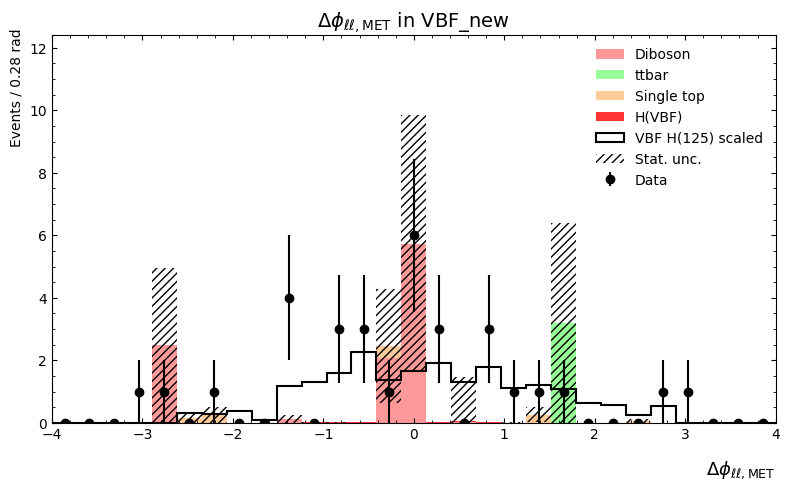

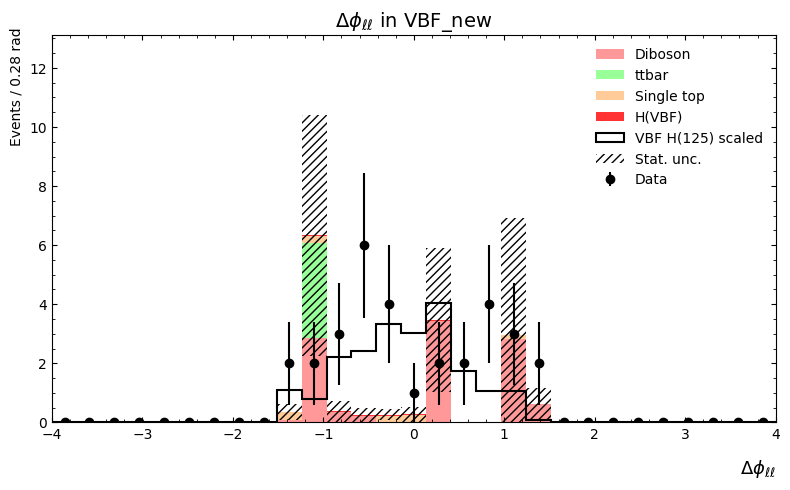

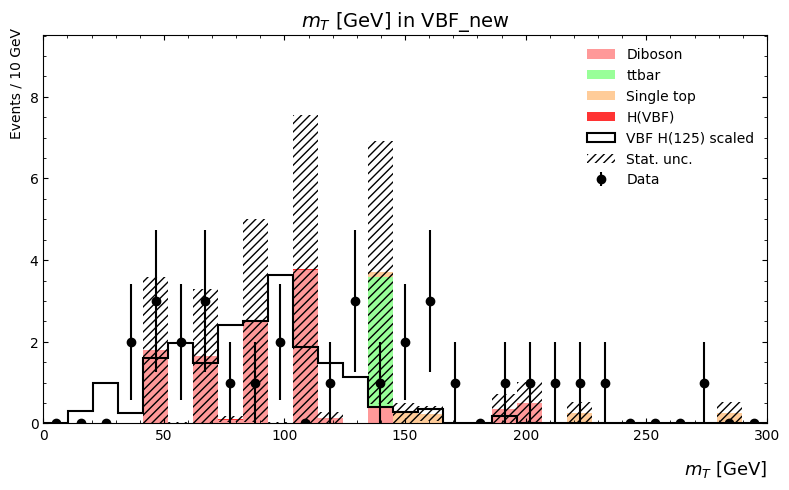

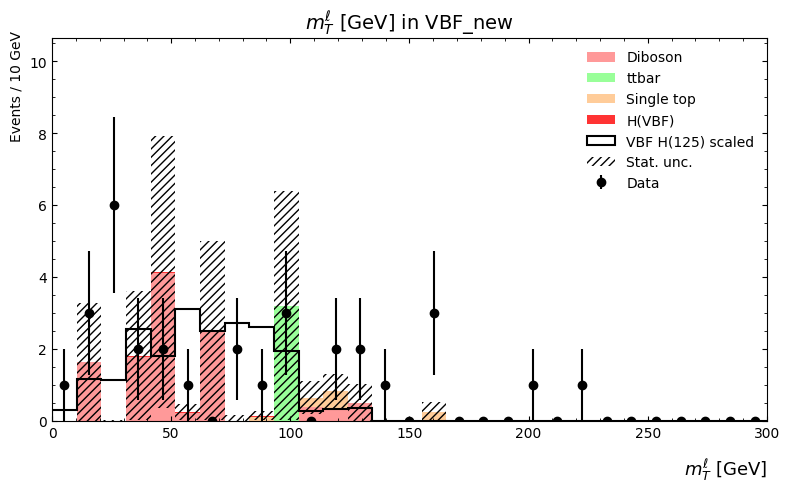

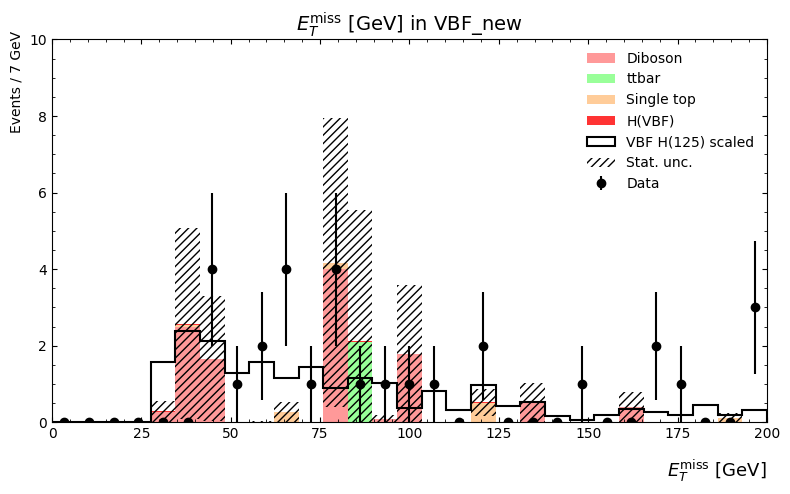

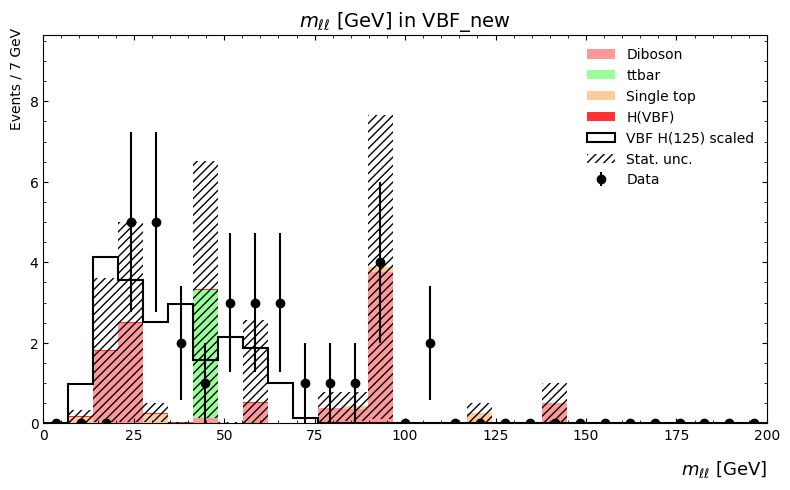

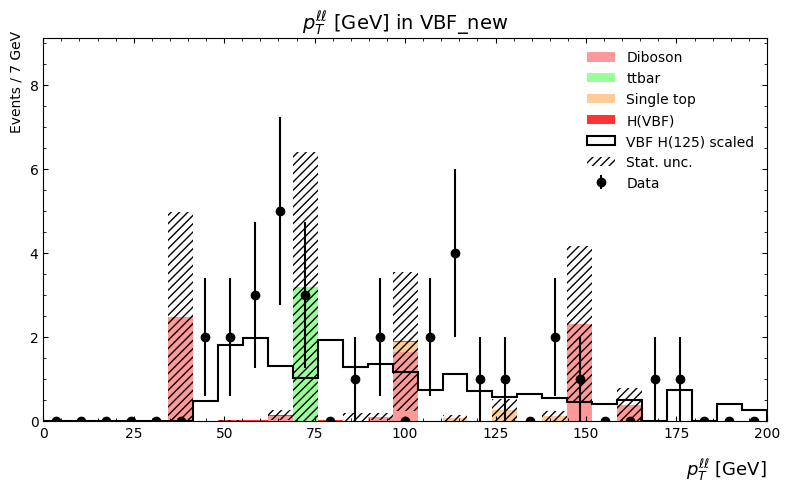

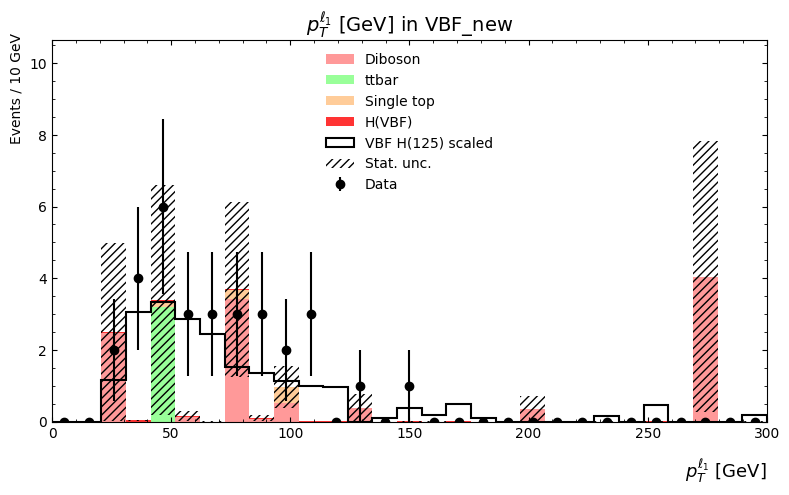

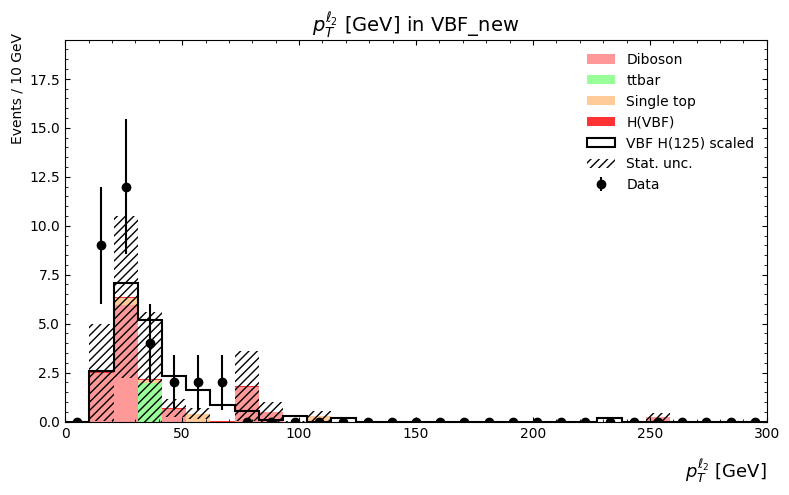

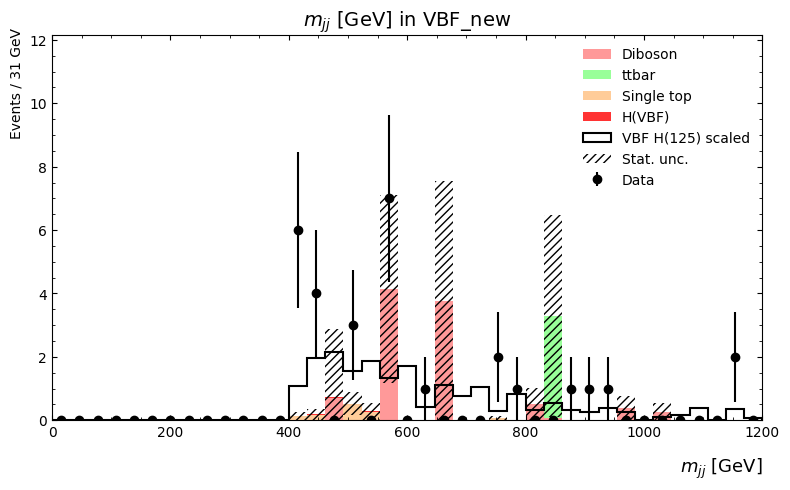

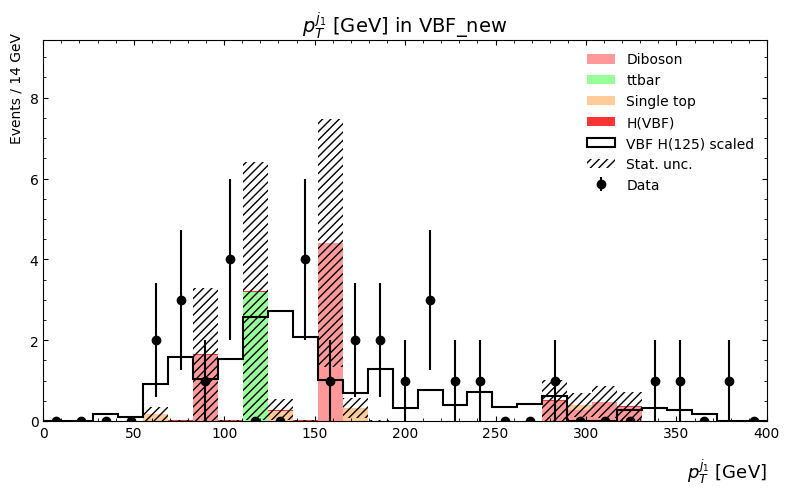

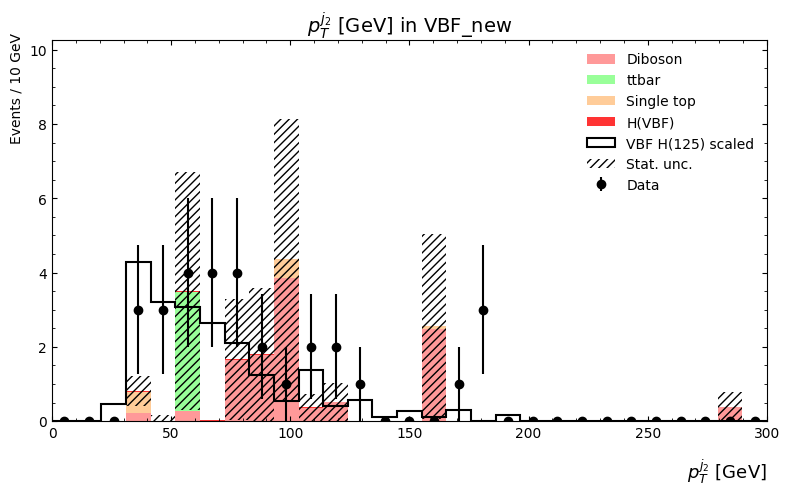

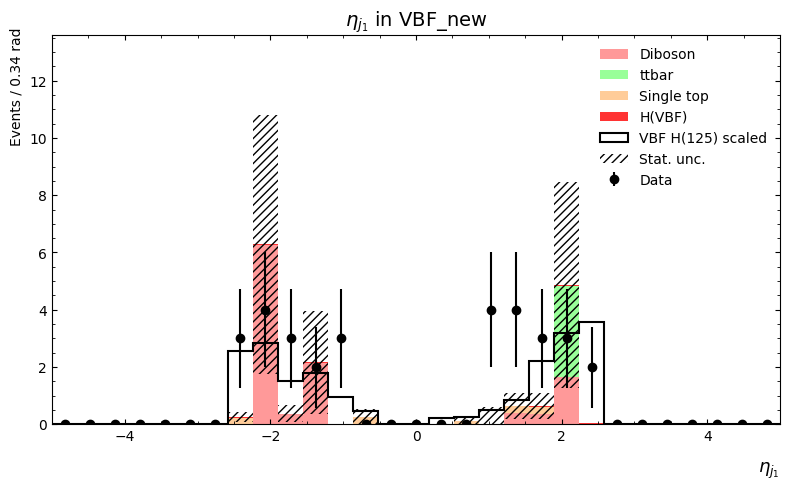

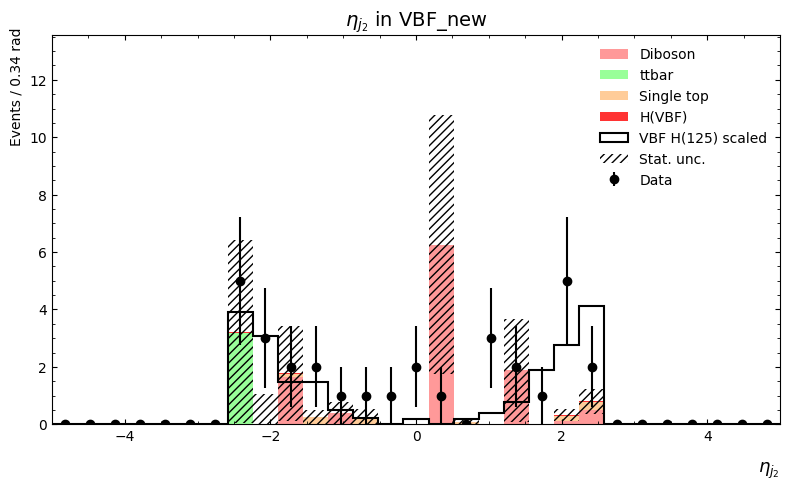

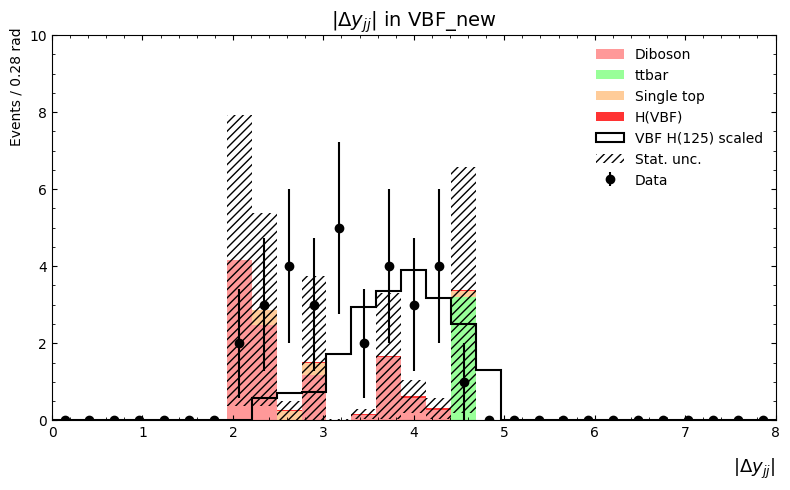

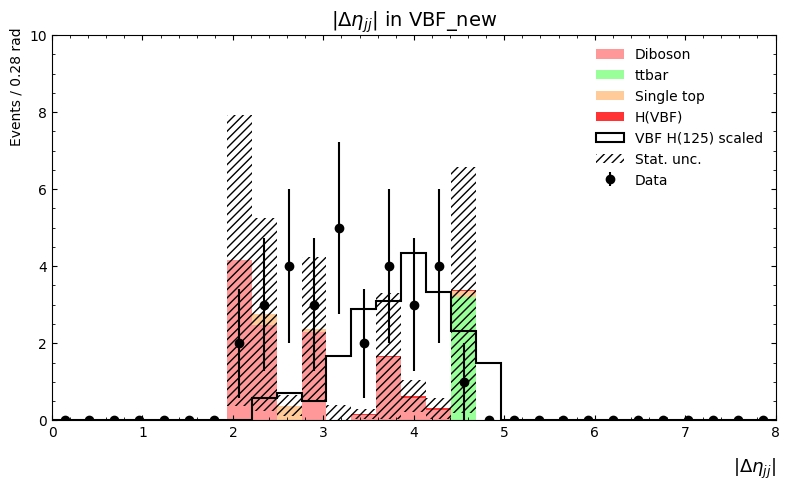

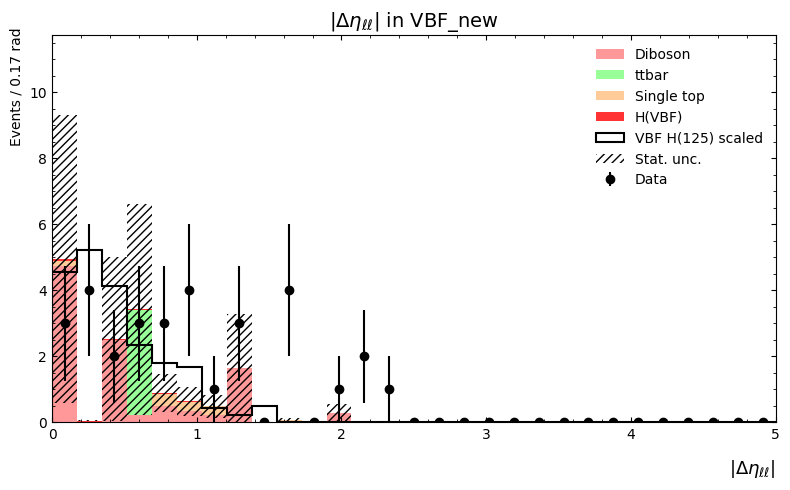

In [5]:
channels = ['VBF_new']  # new SR cuts applied
selection_mode = "full"  # SR
json_dir = "background_json_by_selection_VBF_NEW3" # 2, 3 has 400 GeV cut  # path to directory containing background json files
data_json_dir = "data_json_by_selection_TESTDATA_VBF_NEW3" # path to directory containing background json files

variables_to_plot = {  # dictionary defining variables to plot
    "delta_phi_ll_met": {"xlabel": r"$\Delta\phi_{\ell\ell,\mathrm{MET}}$", "bins": np.linspace(-4, 4, 30)},
    "delta_phi_ll": {"xlabel": r"$\Delta\phi_{\ell\ell}$", "bins": np.linspace(-4, 4, 30)},
    "mT": {"xlabel": r"$m_T$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "mT_ell": {"xlabel": r"$m_T^{\ell}$ [GeV]", "bins": np.linspace(0, 300, 30)},
    "met_et": {"xlabel": r"$E_T^{\mathrm{miss}}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "osof_mass": {"xlabel": r"$m_{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "pT_ll": {"xlabel": r"$p_T^{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "lep_pt_0": {"xlabel": r"$p_T^{\ell_1}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "lep_pt_1": {"xlabel": r"$p_T^{\ell_2}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "mjj": {"xlabel": r"$m_{jj}$ [GeV]", "bins": np.linspace(0, 1200, 40), "scale": 1e-3},
    "jet_pt_0": {"xlabel": r"$p_T^{j_1}$ [GeV]", "bins": np.linspace(0, 400, 30), "scale": 1e-3},
    "jet_pt_1": {"xlabel": r"$p_T^{j_2}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "jet_eta_0": {"xlabel": r"$\eta_{j_1}$", "bins": np.linspace(-5, 5, 30)},
    "jet_eta_1": {"xlabel": r"$\eta_{j_2}$", "bins": np.linspace(-5, 5, 30)},
    "delta_y_jj": {"xlabel": r"$|\Delta y_{jj}|$", "bins": np.linspace(0, 8, 30)},
    "delta_eta_jj": {"xlabel": r"$|\Delta \eta_{jj}|$", "bins": np.linspace(0, 8, 30)},
    "delta_eta_ll": {"xlabel": r"$|\Delta \eta_{\ell\ell}|$", "bins": np.linspace(0, 5, 30)},
}

group_map = {  # map background groups
    "Diboson": ["diboson_leptonic", "diboson_semileptonic"],
    "V+jets": ["Wjets", "Zjets"], 
    "ttbar": ["top"],
    "Single top": ["top"],
    "H(VBF)": ["HWW"],
}

group_colors = {  # assign colors
    "Diboson": "#ff9999",
    "V+jets": "#66b3ff",
    "ttbar": "#99ff99",
    "Single top": "#ffcc99",
    "H(VBF)": "#ff3333",
}

ttbar_samples = ["ttbar_lep"]
single_top_samples = [
    'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan',
    'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan'
]

def load_mc_events(channel, cat, group_name):
    filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:  # open the json file for reading
        content = json.load(f)  # json content into a python dictionary
    events = []
    for sample_name, evts in content["samples"].items():
        if group_name == "ttbar" and sample_name not in ttbar_samples:
            continue
        if group_name == "Single top" and sample_name not in single_top_samples:
            continue
        if group_name == "H(VBF)" and sample_name != "VBFH125_WW2lep":
            continue
        events.extend(evts)
    return events

def load_data_events(channel):
    filepath = os.path.join(data_json_dir, f"data_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:  # open the json file for reading
        content = json.load(f)  # json content into a python dictionary
    all_events = []
    for period_events in content["samples"].values():
        all_events.extend(period_events)
    return all_events

# compute delta eta
def delta_eta(obj_eta):
    return abs(obj_eta[0] - obj_eta[1]) if len(obj_eta) >= 2 else np.nan

# compute rapidity difference
def delta_y_jj(evt):
    idx = np.argsort(evt["jet_pt"])[::-1]
    y1 = 0.5 * np.log((evt["jet_E"][idx[0]] + evt["jet_pt"][idx[0]] * np.sinh(evt["jet_eta"][idx[0]])) /
                     (evt["jet_E"][idx[0]] - evt["jet_pt"][idx[0]] * np.sinh(evt["jet_eta"][idx[0]])))
    y2 = 0.5 * np.log((evt["jet_E"][idx[1]] + evt["jet_pt"][idx[1]] * np.sinh(evt["jet_eta"][idx[1]])) /
                     (evt["jet_E"][idx[1]] - evt["jet_pt"][idx[1]] * np.sinh(evt["jet_eta"][idx[1]])))
    return abs(y1 - y2)

# main loop
for channel in channels:  # loop over analysis channels
    print(f"\n--- Channel: {channel} ---")
    for var, meta in variables_to_plot.items():  # dictionary defining variables to plot
        bin_edges = meta["bins"]
        step_size = bin_edges[1] - bin_edges[0]
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        xlabel = meta["xlabel"]
        scale = meta.get("scale", 1.0)

        fig, ax = plt.subplots(figsize=(8, 5))  # figure
        stack_vals, stack_wgts, stack_colors, stack_labels = [], [], [], []
        all_mc_vals, all_mc_weights = [], []

        for group_name, cats in group_map.items():  # map background groups to their component categories
            group_vals, group_wgts = [], []
            for cat in cats:
                events = load_mc_events(channel, cat, group_name)
                for evt in events:
                    if var.startswith("lep_pt") and "lep_pt" in evt: # lepton variables
                        i = int(var[-1])
                        leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                        if len(leptons_sorted) > i:
                            group_vals.append(leptons_sorted[i] * scale)
                            group_wgts.append(evt.get("weight", 1.0))
                    elif var.startswith("jet_pt") or var.startswith("jet_eta"): # jet variables
                        i = int(var[-1])
                        key = "jet_pt" if "pt" in var else "jet_eta"
                        if key in evt and len(evt[key]) > i:
                            idx = np.argsort(evt["jet_pt"])[::-1]
                            group_vals.append(evt[key][idx[i]] * scale)
                            group_wgts.append(evt.get("weight", 1.0))
                    elif var == "delta_eta_ll" and "lep_eta" in evt: # specific variables
                        group_vals.append(delta_eta(evt["lep_eta"]))
                        group_wgts.append(evt.get("weight", 1.0))
                    elif var == "delta_eta_jj" and "jet_eta" in evt and len(evt["jet_eta"]) >= 2:
                        idx = np.argsort(evt["jet_pt"])[::-1]
                        eta1, eta2 = evt["jet_eta"][idx[0]], evt["jet_eta"][idx[1]]
                        group_vals.append(abs(eta1 - eta2))
                        group_wgts.append(evt.get("weight", 1.0))
                    elif var == "delta_y_jj" and "jet_pt" in evt and len(evt["jet_pt"]) >= 2:
                        group_vals.append(delta_y_jj(evt))
                        group_wgts.append(evt.get("weight", 1.0))
                    elif var in evt: # other variables
                        group_vals.append(evt[var] * scale)
                        group_wgts.append(evt.get("weight", 1.0))
            if group_vals: # if non empty
                stack_vals.append(group_vals)
                stack_wgts.append(group_wgts)
                stack_colors.append(group_colors[group_name])  # assign colors to background groups for plotting
                stack_labels.append(group_name)
                all_mc_vals.append(group_vals)
                all_mc_weights.append(group_wgts)

        if stack_vals: # if non empty - mc stack
            ax.hist(stack_vals, bins=bin_edges, weights=stack_wgts,
                    stacked=True, color=stack_colors, label=stack_labels)
            # errors
            flat_vals = np.hstack(all_mc_vals)
            flat_weights = np.hstack(all_mc_weights)
            mc_totals, _ = np.histogram(flat_vals, bins=bin_edges, weights=flat_weights)  # compute histogram values with weights
            mc_errors = np.sqrt(np.histogram(flat_vals, bins=bin_edges, weights=flat_weights**2)[0])  # compute histogram values with weights
            ax.bar(bin_centres, 2 * mc_errors, bottom=mc_totals - mc_errors,  # overlay statistical uncertainty as error bars
                   alpha=0.5, color='none', hatch="////", width=step_size,
                   label="Stat. unc.")

        #data
        data_vals = load_data_events(channel)
        data_var_vals = []
        for evt in data_vals:
            if var.startswith("lep_pt") and "lep_pt" in evt: # lepton variables
                i = int(var[-1])
                leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                if len(leptons_sorted) > i:
                    data_var_vals.append(leptons_sorted[i] * scale)
            elif var.startswith("jet_pt") or var.startswith("jet_eta"): # jet variables
                i = int(var[-1])
                key = "jet_pt" if "pt" in var else "jet_eta"
                if key in evt and len(evt[key]) > i:
                    idx = np.argsort(evt["jet_pt"])[::-1]
                    data_var_vals.append(evt[key][idx[i]] * scale)
            elif var == "delta_eta_ll" and "lep_eta" in evt: # other specific variables
                data_var_vals.append(delta_eta(evt["lep_eta"]))
            elif var == "delta_eta_jj" and "jet_eta" in evt and len(evt["jet_eta"]) >= 2:
                idx = np.argsort(evt["jet_pt"])[::-1]
                eta1, eta2 = evt["jet_eta"][idx[0]], evt["jet_eta"][idx[1]]
                data_var_vals.append(abs(eta1 - eta2))
            elif var == "delta_y_jj" and "jet_pt" in evt and len(evt["jet_pt"]) >= 2:
                data_var_vals.append(delta_y_jj(evt))
            elif var in evt:
                data_var_vals.append(evt[var] * scale)
        # data plotting and errors
        data_counts, _ = np.histogram(data_var_vals, bins=bin_edges)
        data_errors = np.sqrt(data_counts)
        ax.errorbar(bin_centres, data_counts, yerr=data_errors,
                    fmt='ko', label='Data')

        # VBF signal overlay
        signal_file = os.path.join(json_dir, f"HWW_{channel}_{selection_mode}.json")
        if os.path.exists(signal_file):
            with open(signal_file) as f:  # open the json file for reading
                content = json.load(f)  # json content into a python dictionary
            signal_events = content["samples"].get("VBFH125_WW2lep", [])
            sig_vals, sig_wgts = [], []
            for evt in signal_events:
                if var.startswith("lep_pt") and "lep_pt" in evt: # lepton variables
                    i = int(var[-1])
                    leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                    if len(leptons_sorted) > i:
                        sig_vals.append(leptons_sorted[i] * scale)
                        sig_wgts.append(evt["weight"] * 100)
                elif var.startswith("jet_pt") or var.startswith("jet_eta"): # jet variables
                    i = int(var[-1])
                    key = "jet_pt" if "pt" in var else "jet_eta"
                    if key in evt and len(evt[key]) > i:
                        idx = np.argsort(evt["jet_pt"])[::-1]
                        sig_vals.append(evt[key][idx[i]] * scale)
                        sig_wgts.append(evt["weight"] * 100)
                elif var == "delta_eta_ll" and "lep_eta" in evt: # other specific variables
                    sig_vals.append(delta_eta(evt["lep_eta"]))
                    sig_wgts.append(evt["weight"] * 100)
                elif var == "delta_eta_jj" and "jet_eta" in evt and len(evt["jet_eta"]) >= 2:
                    idx = np.argsort(evt["jet_pt"])[::-1]
                    eta1, eta2 = evt["jet_eta"][idx[0]], evt["jet_eta"][idx[1]]
                    sig_vals.append(abs(eta1 - eta2))
                    sig_wgts.append(evt["weight"] * 100)
                elif var == "delta_y_jj" and "jet_pt" in evt and len(evt["jet_pt"]) >= 2:
                    sig_vals.append(delta_y_jj(evt))
                    sig_wgts.append(evt["weight"] * 100)
                elif var in evt:
                    sig_vals.append(evt[var] * scale)
                    sig_wgts.append(evt["weight"] * 100)

            if sig_vals: # if non empty
                ax.hist(sig_vals, bins=bin_edges, weights=sig_wgts,
                        histtype="step", linewidth=1.5, linestyle="-",
                        label="VBF H(125) scaled", color="black")

        # plot
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # set x-axis range
        ymax = max(max(mc_totals + mc_errors, default=0), max(data_counts + data_errors, default=0)) * 1.4
        ax.set_ylim(bottom=0, top=ymax*0.9)  # set y-axis lower and upper limits
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.set_xlabel(xlabel, fontsize=13, x=1, ha='right', labelpad=12)  # label the x-axis
        ylabel_unit = "GeV" if "GeV" in xlabel else "rad"
        step_label = f'{step_size:.0f}' if step_size >= 1 else f'{step_size:.2f}'
        ax.set_ylabel(f'Events / {step_label} {ylabel_unit}', y=1.02, ha='right')  # label the y-axis
        ax.legend(frameon=False) 
        ax.set_title(f"{xlabel} in {channel}", fontsize=14)  
        plt.tight_layout() 
        plt.subplots_adjust(top=0.92) 
        plt.show() 


--- Channel: VBF_new ---


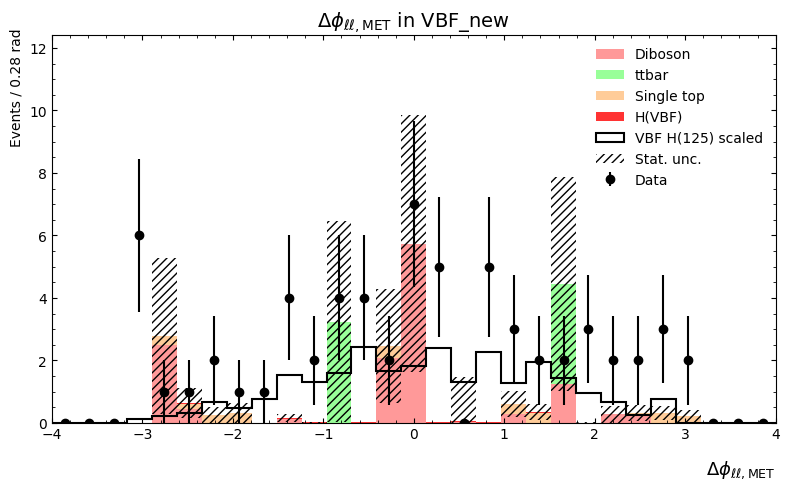

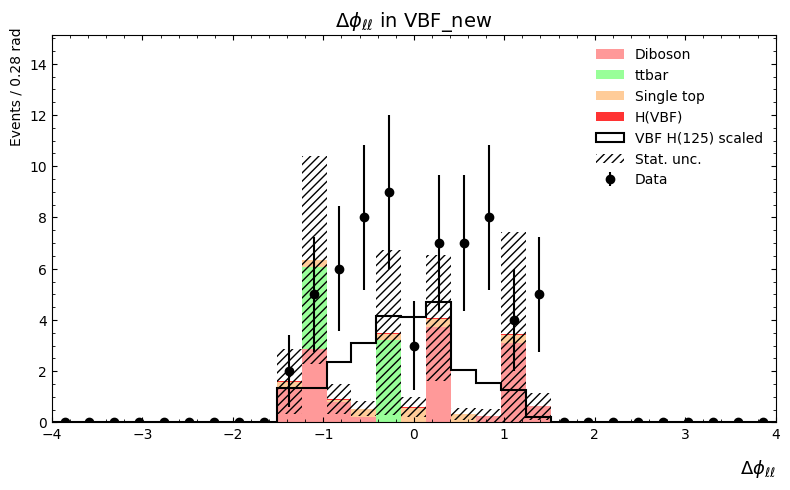

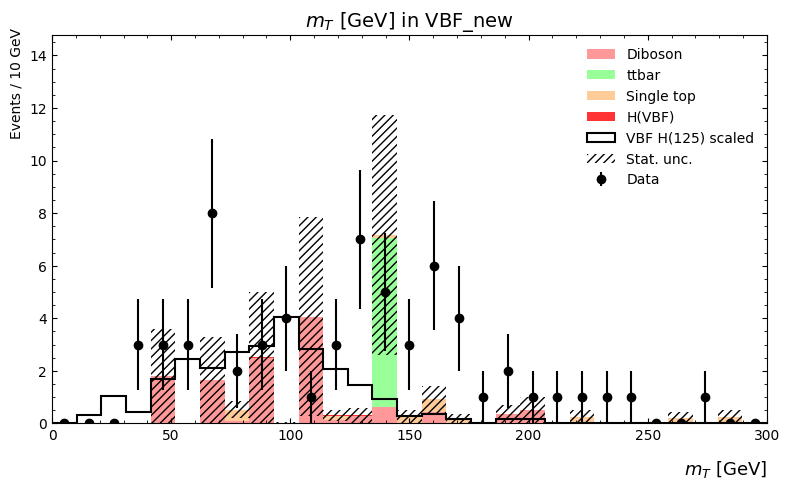

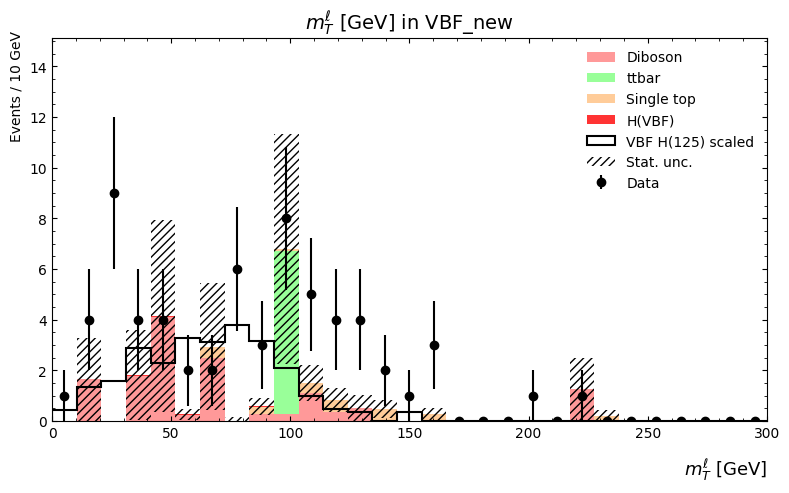

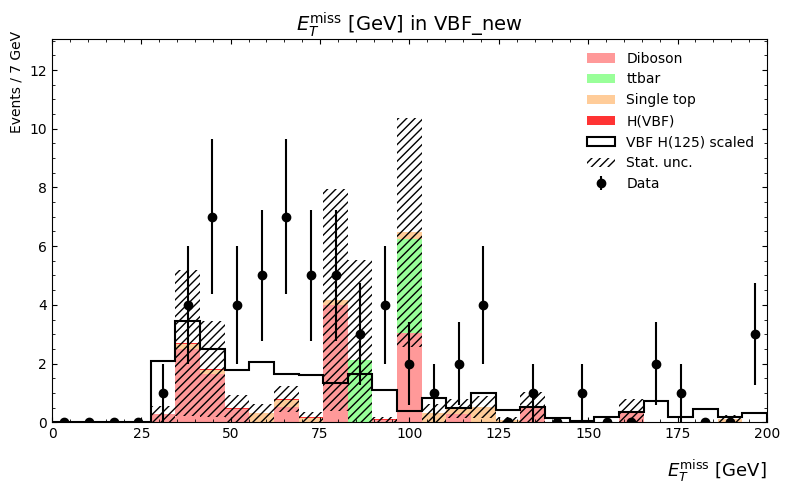

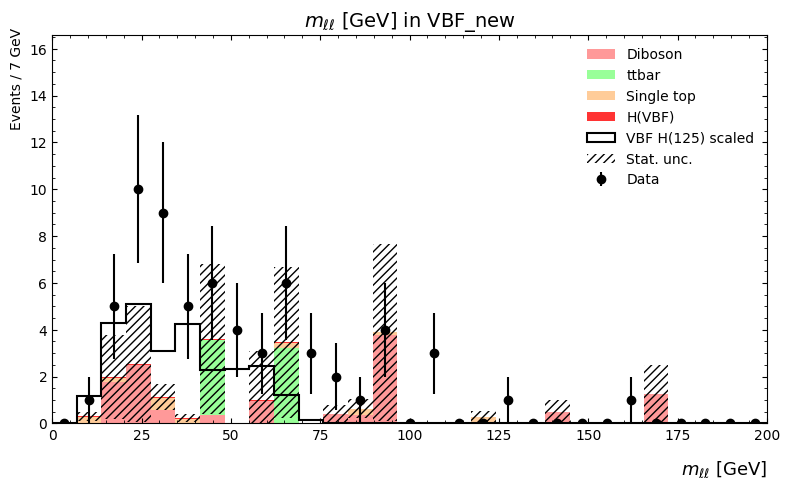

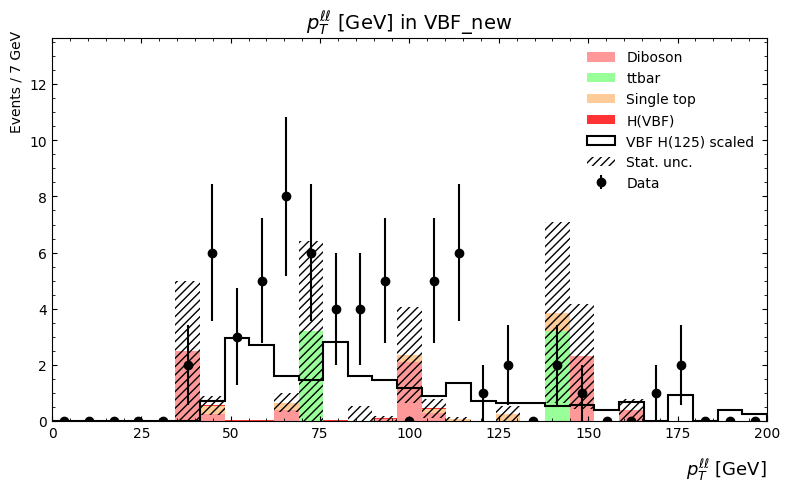

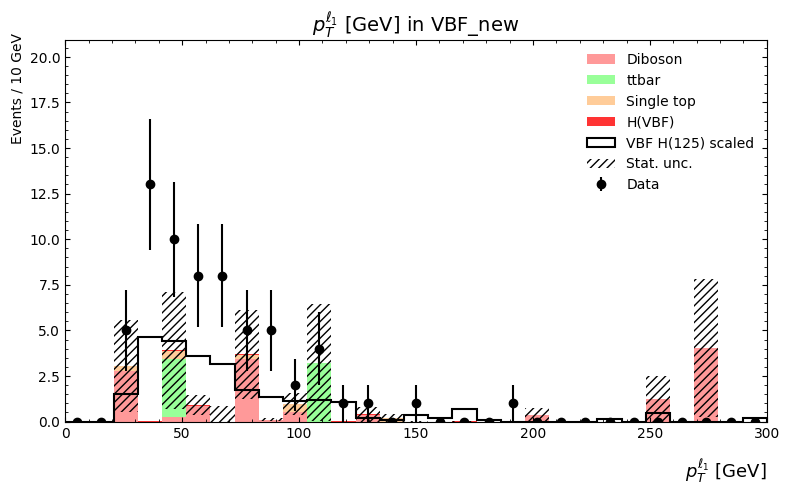

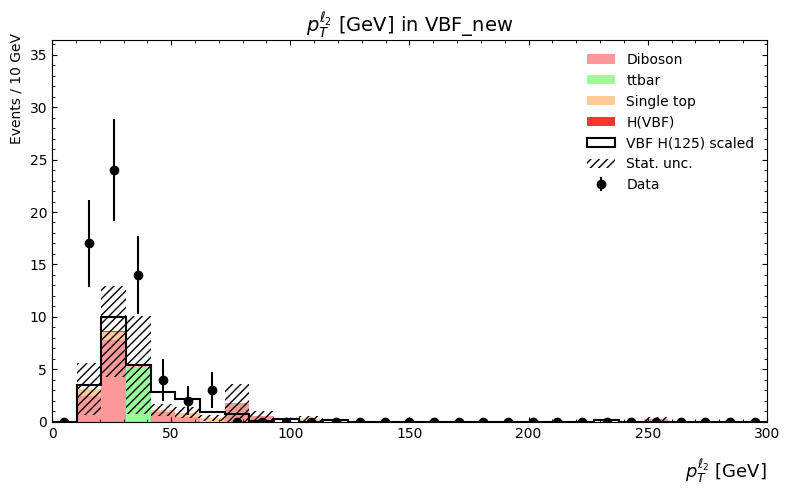

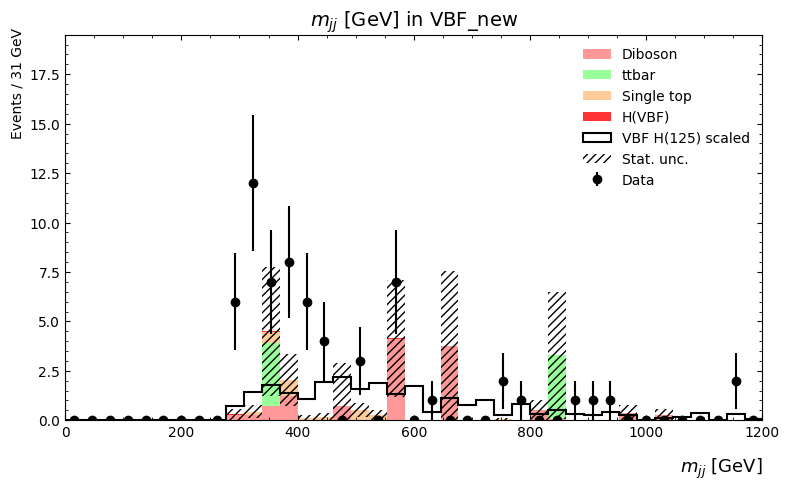

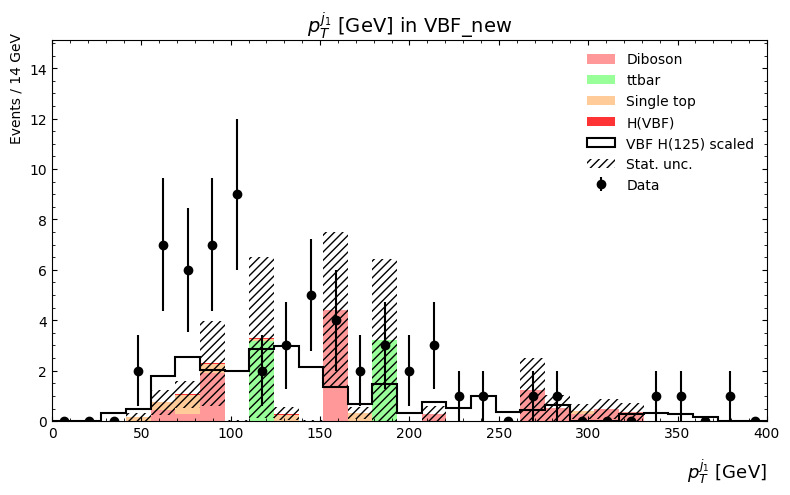

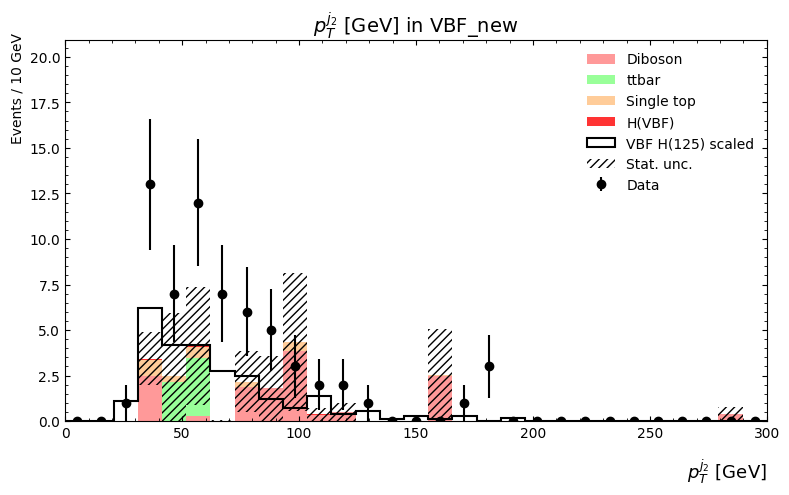

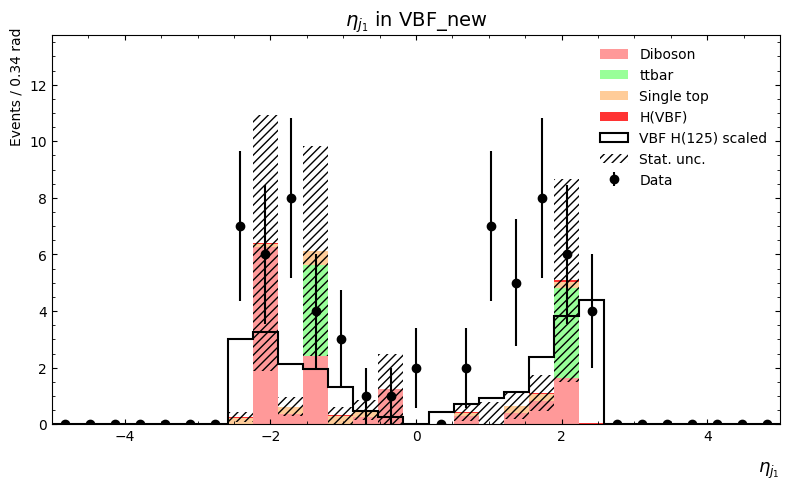

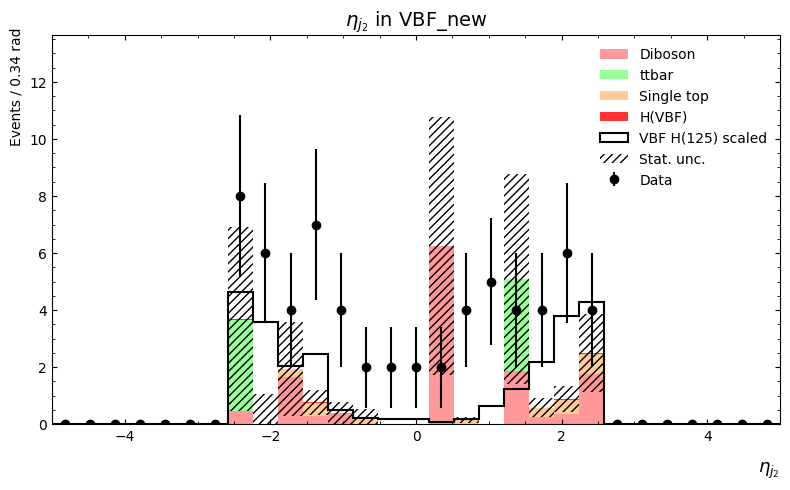

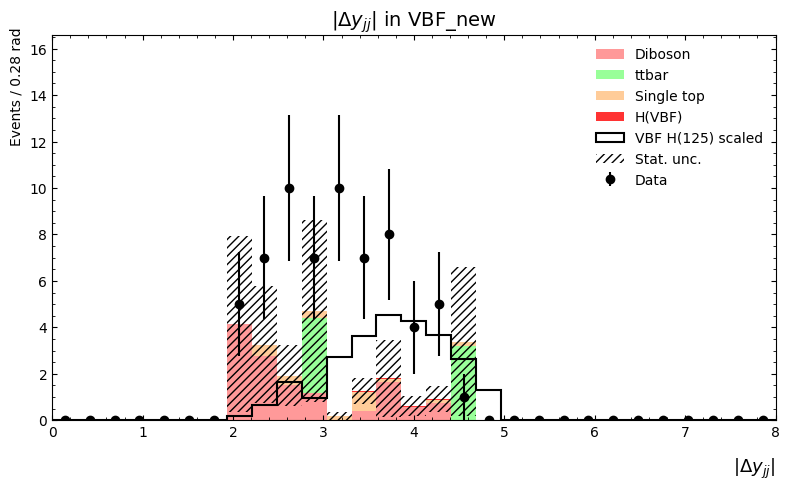

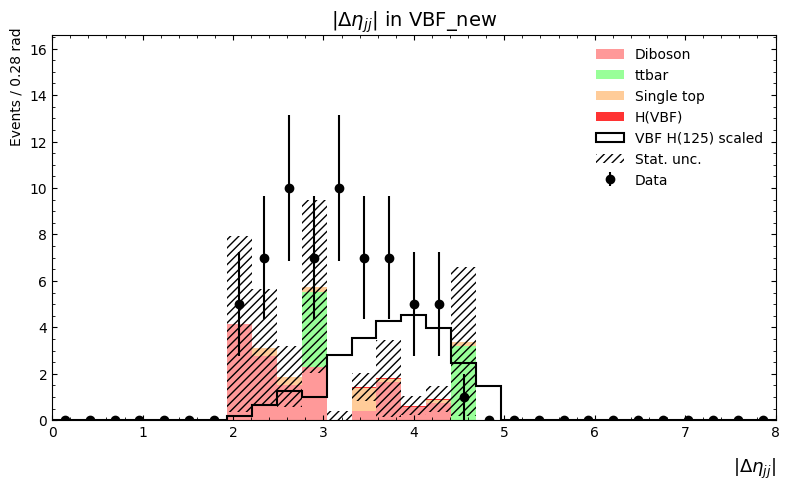

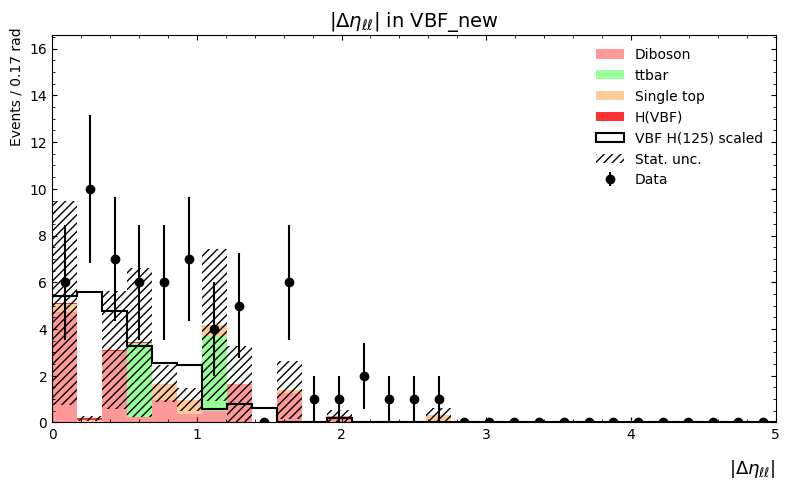

In [8]:
channels = ['VBF_new']  # new SR cuts applied
selection_mode = "full"  # SR
json_dir = "background_json_by_selection_testing3" # 2, 3 has 400 GeV cut  # path to directory containing background json files
data_json_dir = "data_json_by_selection_testing_vbf3" # no num 

variables_to_plot = {  # dictionary defining variables to plot
    "delta_phi_ll_met": {"xlabel": r"$\Delta\phi_{\ell\ell,\mathrm{MET}}$", "bins": np.linspace(-4, 4, 30)},
    "delta_phi_ll": {"xlabel": r"$\Delta\phi_{\ell\ell}$", "bins": np.linspace(-4, 4, 30)},
    "mT": {"xlabel": r"$m_T$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "mT_ell": {"xlabel": r"$m_T^{\ell}$ [GeV]", "bins": np.linspace(0, 300, 30)},
    "met_et": {"xlabel": r"$E_T^{\mathrm{miss}}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "osof_mass": {"xlabel": r"$m_{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "pT_ll": {"xlabel": r"$p_T^{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "lep_pt_0": {"xlabel": r"$p_T^{\ell_1}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "lep_pt_1": {"xlabel": r"$p_T^{\ell_2}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "mjj": {"xlabel": r"$m_{jj}$ [GeV]", "bins": np.linspace(0, 1200, 40), "scale": 1e-3},
    "jet_pt_0": {"xlabel": r"$p_T^{j_1}$ [GeV]", "bins": np.linspace(0, 400, 30), "scale": 1e-3},
    "jet_pt_1": {"xlabel": r"$p_T^{j_2}$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},
    "jet_eta_0": {"xlabel": r"$\eta_{j_1}$", "bins": np.linspace(-5, 5, 30)},
    "jet_eta_1": {"xlabel": r"$\eta_{j_2}$", "bins": np.linspace(-5, 5, 30)},
    "delta_y_jj": {"xlabel": r"$|\Delta y_{jj}|$", "bins": np.linspace(0, 8, 30)},
    "delta_eta_jj": {"xlabel": r"$|\Delta \eta_{jj}|$", "bins": np.linspace(0, 8, 30)},
    "delta_eta_ll": {"xlabel": r"$|\Delta \eta_{\ell\ell}|$", "bins": np.linspace(0, 5, 30)},
}

group_map = {  # map background groups
    "Diboson": ["diboson_leptonic", "diboson_semileptonic"],
    "V+jets": ["Wjets", "Zjets"], 
    "ttbar": ["top"],
    "Single top": ["top"],
    "H(VBF)": ["HWW"],
}

group_colors = {  # assign colors
    "Diboson": "#ff9999",
    "V+jets": "#66b3ff",
    "ttbar": "#99ff99",
    "Single top": "#ffcc99",
    "H(VBF)": "#ff3333",
}

ttbar_samples = ["ttbar_lep"]
single_top_samples = [
    'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan',
    'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan'
]

def load_mc_events(channel, cat, group_name):
    filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:  # open the json file for reading
        content = json.load(f)  # json content into a python dictionary
    events = []
    for sample_name, evts in content["samples"].items():
        if group_name == "ttbar" and sample_name not in ttbar_samples:
            continue
        if group_name == "Single top" and sample_name not in single_top_samples:
            continue
        if group_name == "H(VBF)" and sample_name != "VBFH125_WW2lep":
            continue
        events.extend(evts)
    return events

def load_data_events(channel):
    filepath = os.path.join(data_json_dir, f"data_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:  # open the json file for reading
        content = json.load(f)  # json content into a python dictionary
    all_events = []
    for period_events in content["samples"].values():
        all_events.extend(period_events)
    return all_events

# compute delta eta
def delta_eta(obj_eta):
    return abs(obj_eta[0] - obj_eta[1]) if len(obj_eta) >= 2 else np.nan

# compute rapidity difference
def delta_y_jj(evt):
    idx = np.argsort(evt["jet_pt"])[::-1]
    y1 = 0.5 * np.log((evt["jet_E"][idx[0]] + evt["jet_pt"][idx[0]] * np.sinh(evt["jet_eta"][idx[0]])) /
                     (evt["jet_E"][idx[0]] - evt["jet_pt"][idx[0]] * np.sinh(evt["jet_eta"][idx[0]])))
    y2 = 0.5 * np.log((evt["jet_E"][idx[1]] + evt["jet_pt"][idx[1]] * np.sinh(evt["jet_eta"][idx[1]])) /
                     (evt["jet_E"][idx[1]] - evt["jet_pt"][idx[1]] * np.sinh(evt["jet_eta"][idx[1]])))
    return abs(y1 - y2)

# main loop
for channel in channels:  # loop over analysis channels
    print(f"\n--- Channel: {channel} ---")
    for var, meta in variables_to_plot.items():  # dictionary defining variables to plot
        bin_edges = meta["bins"]
        step_size = bin_edges[1] - bin_edges[0]
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        xlabel = meta["xlabel"]
        scale = meta.get("scale", 1.0)

        fig, ax = plt.subplots(figsize=(8, 5))  # figure
        stack_vals, stack_wgts, stack_colors, stack_labels = [], [], [], []
        all_mc_vals, all_mc_weights = [], []

        for group_name, cats in group_map.items():  # map background groups to their component categories
            group_vals, group_wgts = [], []
            for cat in cats:
                events = load_mc_events(channel, cat, group_name)
                for evt in events:
                    if var.startswith("lep_pt") and "lep_pt" in evt: # lepton variables
                        i = int(var[-1])
                        leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                        if len(leptons_sorted) > i:
                            group_vals.append(leptons_sorted[i] * scale)
                            group_wgts.append(evt.get("weight", 1.0))
                    elif var.startswith("jet_pt") or var.startswith("jet_eta"): # jet variables
                        i = int(var[-1])
                        key = "jet_pt" if "pt" in var else "jet_eta"
                        if key in evt and len(evt[key]) > i:
                            idx = np.argsort(evt["jet_pt"])[::-1]
                            group_vals.append(evt[key][idx[i]] * scale)
                            group_wgts.append(evt.get("weight", 1.0))
                    elif var == "delta_eta_ll" and "lep_eta" in evt: # specific variables
                        group_vals.append(delta_eta(evt["lep_eta"]))
                        group_wgts.append(evt.get("weight", 1.0))
                    elif var == "delta_eta_jj" and "jet_eta" in evt and len(evt["jet_eta"]) >= 2:
                        idx = np.argsort(evt["jet_pt"])[::-1]
                        eta1, eta2 = evt["jet_eta"][idx[0]], evt["jet_eta"][idx[1]]
                        group_vals.append(abs(eta1 - eta2))
                        group_wgts.append(evt.get("weight", 1.0))
                    elif var == "delta_y_jj" and "jet_pt" in evt and len(evt["jet_pt"]) >= 2:
                        group_vals.append(delta_y_jj(evt))
                        group_wgts.append(evt.get("weight", 1.0))
                    elif var in evt: # other variables
                        group_vals.append(evt[var] * scale)
                        group_wgts.append(evt.get("weight", 1.0))
            if group_vals: # if non empty
                stack_vals.append(group_vals)
                stack_wgts.append(group_wgts)
                stack_colors.append(group_colors[group_name])  # assign colors to background groups for plotting
                stack_labels.append(group_name)
                all_mc_vals.append(group_vals)
                all_mc_weights.append(group_wgts)

        if stack_vals: # if non empty - mc stack
            ax.hist(stack_vals, bins=bin_edges, weights=stack_wgts,
                    stacked=True, color=stack_colors, label=stack_labels)
            # errors
            flat_vals = np.hstack(all_mc_vals)
            flat_weights = np.hstack(all_mc_weights)
            mc_totals, _ = np.histogram(flat_vals, bins=bin_edges, weights=flat_weights)  # compute histogram values with weights
            mc_errors = np.sqrt(np.histogram(flat_vals, bins=bin_edges, weights=flat_weights**2)[0])  # compute histogram values with weights
            ax.bar(bin_centres, 2 * mc_errors, bottom=mc_totals - mc_errors,  # overlay statistical uncertainty as error bars
                   alpha=0.5, color='none', hatch="////", width=step_size,
                   label="Stat. unc.")

        #data
        data_vals = load_data_events(channel)
        data_var_vals = []
        for evt in data_vals:
            if var.startswith("lep_pt") and "lep_pt" in evt: # lepton variables
                i = int(var[-1])
                leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                if len(leptons_sorted) > i:
                    data_var_vals.append(leptons_sorted[i] * scale)
            elif var.startswith("jet_pt") or var.startswith("jet_eta"): # jet variables
                i = int(var[-1])
                key = "jet_pt" if "pt" in var else "jet_eta"
                if key in evt and len(evt[key]) > i:
                    idx = np.argsort(evt["jet_pt"])[::-1]
                    data_var_vals.append(evt[key][idx[i]] * scale)
            elif var == "delta_eta_ll" and "lep_eta" in evt: # other specific variables
                data_var_vals.append(delta_eta(evt["lep_eta"]))
            elif var == "delta_eta_jj" and "jet_eta" in evt and len(evt["jet_eta"]) >= 2:
                idx = np.argsort(evt["jet_pt"])[::-1]
                eta1, eta2 = evt["jet_eta"][idx[0]], evt["jet_eta"][idx[1]]
                data_var_vals.append(abs(eta1 - eta2))
            elif var == "delta_y_jj" and "jet_pt" in evt and len(evt["jet_pt"]) >= 2:
                data_var_vals.append(delta_y_jj(evt))
            elif var in evt:
                data_var_vals.append(evt[var] * scale)
        # data plotting and errors
        data_counts, _ = np.histogram(data_var_vals, bins=bin_edges)
        data_errors = np.sqrt(data_counts)
        ax.errorbar(bin_centres, data_counts, yerr=data_errors,
                    fmt='ko', label='Data')

        # VBF signal overlay
        signal_file = os.path.join(json_dir, f"HWW_{channel}_{selection_mode}.json")
        if os.path.exists(signal_file):
            with open(signal_file) as f:  # open the json file for reading
                content = json.load(f)  # json content into a python dictionary
            signal_events = content["samples"].get("VBFH125_WW2lep", [])
            sig_vals, sig_wgts = [], []
            for evt in signal_events:
                if var.startswith("lep_pt") and "lep_pt" in evt: # lepton variables
                    i = int(var[-1])
                    leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                    if len(leptons_sorted) > i:
                        sig_vals.append(leptons_sorted[i] * scale)
                        sig_wgts.append(evt["weight"] * 100)
                elif var.startswith("jet_pt") or var.startswith("jet_eta"): # jet variables
                    i = int(var[-1])
                    key = "jet_pt" if "pt" in var else "jet_eta"
                    if key in evt and len(evt[key]) > i:
                        idx = np.argsort(evt["jet_pt"])[::-1]
                        sig_vals.append(evt[key][idx[i]] * scale)
                        sig_wgts.append(evt["weight"] * 100)
                elif var == "delta_eta_ll" and "lep_eta" in evt: # other specific variables
                    sig_vals.append(delta_eta(evt["lep_eta"]))
                    sig_wgts.append(evt["weight"] * 100)
                elif var == "delta_eta_jj" and "jet_eta" in evt and len(evt["jet_eta"]) >= 2:
                    idx = np.argsort(evt["jet_pt"])[::-1]
                    eta1, eta2 = evt["jet_eta"][idx[0]], evt["jet_eta"][idx[1]]
                    sig_vals.append(abs(eta1 - eta2))
                    sig_wgts.append(evt["weight"] * 100)
                elif var == "delta_y_jj" and "jet_pt" in evt and len(evt["jet_pt"]) >= 2:
                    sig_vals.append(delta_y_jj(evt))
                    sig_wgts.append(evt["weight"] * 100)
                elif var in evt:
                    sig_vals.append(evt[var] * scale)
                    sig_wgts.append(evt["weight"] * 100)

            if sig_vals: # if non empty
                ax.hist(sig_vals, bins=bin_edges, weights=sig_wgts,
                        histtype="step", linewidth=1.5, linestyle="-",
                        label="VBF H(125) scaled", color="black")

        # plot
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # set x-axis range
        ymax = max(max(mc_totals + mc_errors, default=0), max(data_counts + data_errors, default=0)) * 1.4
        ax.set_ylim(bottom=0, top=ymax*0.9)  # set y-axis lower and upper limits
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.set_xlabel(xlabel, fontsize=13, x=1, ha='right', labelpad=12)  # label the x-axis
        ylabel_unit = "GeV" if "GeV" in xlabel else "rad"
        step_label = f'{step_size:.0f}' if step_size >= 1 else f'{step_size:.2f}'
        ax.set_ylabel(f'Events / {step_label} {ylabel_unit}', y=1.02, ha='right')  # label the y-axis
        ax.legend(frameon=False) 
        ax.set_title(f"{xlabel} in {channel}", fontsize=14)  
        plt.tight_layout() 
        plt.subplots_adjust(top=0.92) 
        plt.show() 

# checking VBF cuts

# original SR

In [6]:
import os  # import module for file system operations
import json  # import module to read json files


channels = ['VBF']  # VBF 
selection_mode = "full"  # SR
json_dir = 'background_json_by_selection_updated4' # original SR  s
# count events per group
counts = {group: 0 for group in group_map.keys()} 
# loop through
for channel in channels: 
    for group, cats in group_map.items():  # map background groups to their component categories
        total = 0 # set total to 0 to start with
        for cat in cats:
            filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")
            if not os.path.exists(filepath):
                continue
            with open(filepath) as f:  # open the json file for reading
                content = json.load(f)  # json content into a python dictionary
            for sample_name, events in content["samples"].items():
                if group == "ttbar" and sample_name not in ttbar_samples:
                    continue
                if group == "Single top" and sample_name not in single_top_samples:
                    continue
                if group == "H(VBF)" and sample_name != "VBFH125_WW2lep":
                    continue
                total += len(events)
        counts[group] = total
print(counts)

{'Diboson': 153, 'V+jets': 12, 'ttbar': 89, 'Single top': 183, 'H(VBF)': 293}


# with cuts adjusted

In [7]:
import os  # import module for file system operations
import json  # import module to read json files

channels = ['VBF_new']  # new VBF selections
selection_mode = "full"  # SR

group_map = {  # map background groups
    "Diboson": ["diboson_leptonic", "diboson_semileptonic"],
    "V+jets": ["Wjets", "Zjets"], 
    "ttbar": ["top"],
    "Single top": ["top"],
    "H(VBF)": ["HWW"],
}

ttbar_samples = ["ttbar_lep"]
single_top_samples = [
    'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan',
    'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan'
]

def count_events_in_dir(json_dir):
    counts = {group: 0 for group in group_map.keys()}  # map background groups to their component categories
    for channel in channels:  # loop over analysis channels
        for group, cats in group_map.items(): 
            total = 0 # start with 0 then add from there
            for cat in cats:
                filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")
                if not os.path.exists(filepath):
                    continue
                with open(filepath) as f:  # open the json file for reading
                    content = json.load(f)  # json content into a python dictionary
                for sample_name, events in content["samples"].items():
                    if group == "ttbar" and sample_name not in ttbar_samples:
                        continue
                    if group == "Single top" and sample_name not in single_top_samples:
                        continue
                    if group == "H(VBF)" and sample_name != "VBFH125_WW2lep":
                        continue
                    total += len(events)
            counts[group] = total
    return counts

# list of (directory, label) pairs
json_dirs_with_labels = [
    ("background_json_by_selection_VBF_NEW2",   "mjj > 450 GeV"),
    ("background_json_by_selection_VBF_NEW3",   "mjj > 400 GeV"),
    ("background_json_by_selection_testing",    "mjj > 400 GeV, delta_y_jj > 1.5"),
    ("background_json_by_selection_testing2",   "mjj > 350 GeV, delta_y_jj > 2"),
    ("background_json_by_selection_testing3",   "mjj > 300 GeV, delta_y_jj > 2"),
    ("background_json_by_selection_testing4",   "mjj > 350 GeV, delta_y_jj > 2, delta_phi_ll < 1.7"),
]

# print a table like thing
print("Selection".ljust(55), end="")
for group in group_map.keys(): 
    print(f"{group:>15}", end="")
print()

# print counts for each directory/selection
for dir_name, label in json_dirs_with_labels:
    result = count_events_in_dir(dir_name)
    print(label.ljust(55), end="")
    for group in group_map.keys(): 
        print(f"{result[group]:15}", end="")
    print()  # new line after each row to make it look better


Selection                                                      Diboson         V+jets          ttbar     Single top         H(VBF)
mjj > 450 GeV                                                       12              0              1              4            129
mjj > 400 GeV                                                       12              0              1              6            150
mjj > 400 GeV, delta_y_jj > 1.5                                     14              0              1              7            150
mjj > 350 GeV, delta_y_jj > 2                                       15              0              1             11            170
mjj > 300 GeV, delta_y_jj > 2                                       18              0              2             14            189
mjj > 350 GeV, delta_y_jj > 2, delta_phi_ll < 1.7                   17              1              1             13            174
